# Does adding an Indian Ocean (IO) box improve the NDI?

In [1]:
'''
   Motivation: Impacts of Different Types of ENSO Events on
   Thermocline Variability in the Southern Tropical Indian
   Ocean
   
   Authors: Liu et al. 2019
   ....
   The paper by Liu et al. 2019 shows that a region in the
   Indian Ocean has a strong relationship with ENSO, which they
   call the southern tropical Indian Ocean (STIO) region 
   (70°E-85°E,8°S-17°S). They discuss the "Z20A", which
   is anomalous thermocline depth variation, for the STIO region
   relationship with anomalous thermocline variations in the 
   Maritime Continent (MC) and Eastern Pacific (EP) region.
   
   Thermocline variability is part of the feedback process that
   drives sea surface temperature anomalies (SSTa) observed in the
   EP and MC region during ENSO events. For example, during an 
   El Niño, easterly trade winds weaken. Weaker than normal trade winds
   allow the thermocline to flatten in the Eastern Pacific region 
   starting from the western coast of South America towards the dateline.
   This allows for the development of anomalously warm sea surface
   temperatures in Eastern Pacific region. Liu et al. 2019 demonstrates 
   that the STIO region has a strong relationship to ENSO driven SSTa in 
   the EP and MC region.
   
   Prior research has also made an argument that ENSO influences the 
   Indian Ocean Dipole (IOD).
   
   E.g., Revisiting ENSO/Indian Ocean Dipole phase relationships
   Authors: Stuecker et al. 2017
   
   The IOD index measures the sea surface temperature difference 
   between the western (50°E-70°E,10°N-10°S) and south eastern 
   (90°E-110°E,0°-10°S). The IOD index (+/- SST box difference) indicates 
   conditions that affect the Indian monsoon as well as rainfall patterns
   in Australia and Africa.
   
   Since this region is intertwined with ENSO, then adding a box from 
   this region to the NDI, which is the difference between an EP and
   MC box (EP-MC), could improve the forecasting ability of the NDI. 
   Also, it could improve the relationship it has with different 
   metrics of the ENSO driven atmospheric response.
   
   One feature that would have to change is that adding a third region 
   to the NDI would force it to be a SST anomaly index rather than have
   it be a raw SST index. This isn't a problem, but is something to mention.
   
   This is the process I went through to determine if adding an IO box
   would improve the NDI.
'''

#For plotting figures below cell
%matplotlib inline 
#import rest of packages
import datetime as dt
import numpy as np
from netCDF4 import Dataset, num2date
import matplotlib.pyplot as plt
import csv as csv
import pandas as pd
from sklearn.decomposition import PCA
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from matplotlib.patches import Rectangle

In [2]:
ENSOdir  = "C:\\Users\\Owner\\Documents\\python_dir\\ENSO_dir\\data_files\\"
ERSST    = ENSOdir + "ERSST\\sst.mnmean_updated.nc"
GPCP     = ENSOdir + "GPCP\\precip.mon.mean_updated.nc"

### "ncdump" function to make .nc data information more readable

In [3]:
'''

Source: Chris Slocum
    http://schubert.atmos.colostate.edu/~cslocum/netcdf_example.html
'''

def ncdump(nc_fid, verb=True):
    '''
    ncdump outputs dimensions, variables and their attribute information.
    The information is similar to that of NCAR's ncdump utility.
    ncdump requires a valid instance of Dataset.   
    
    Parameters
    ----------
    nc_fid : netCDF4.Dataset
        A netCDF4 dateset object
    verb : Boolean
        whether or not nc_attrs, nc_dims, and nc_vars are printed

    Returns
    -------
    nc_attrs : list
        A Python list of the NetCDF file global attributes
    nc_dims : list
        A Python list of the NetCDF file dimensions
    nc_vars : list
        A Python list of the NetCDF file variables
    '''
    def print_ncattr(key):
        """
        Prints the NetCDF file attributes for a given key

        Parameters
        ----------
        key : unicode
            a valid netCDF4.Dataset.variables key
        """
        try:
            print("\t\ttype:", repr(nc_fid.variables[key].dtype))
            for ncattr in nc_fid.variables[key].ncattrs():
                print('\t\t%s:' % ncattr,
                      repr(nc_fid.variables[key].getncattr(ncattr)))
        except KeyError:
            print("\t\tWARNING: %s does not contain variable attributes" % key)

    # NetCDF global attributes
    nc_attrs = nc_fid.ncattrs()
    if verb:
        print("NetCDF Global Attributes:")
        for nc_attr in nc_attrs:
            print('\t%s:' % nc_attr, repr(nc_fid.getncattr(nc_attr)))
    nc_dims = [dim for dim in nc_fid.dimensions]  # list of nc dimensions
    # Dimension shape information.
    if verb:
        print("NetCDF dimension information:")
        for dim in nc_dims:
            print("\tName:", dim)
            print("\t\tsize:", len(nc_fid.dimensions[dim]))
            print_ncattr(dim)
    # Variable information.
    nc_vars = [var for var in nc_fid.variables]  # list of nc variables
    if verb:
        print("NetCDF variable information:")
        for var in nc_vars:
            if var not in nc_dims:
                print('\tName:', var)
                print("\t\tdimensions:", nc_fid.variables[var].dimensions)
                print("\t\tsize:", nc_fid.variables[var].size)
                print_ncattr(var)
    return nc_attrs, nc_dims, nc_vars

### Class used for indexing latitude and <br> longitude bounds with gridded datasets

In [4]:
''' 
    Recieved from Dr. John Nielsen-Gammon
    
    Define new class to extract gridded lon, lat data 
    using bounds of the desired region of data you want. 
    Input: Lat/Lon coordinates
'''

class LatLon:
    #This is why input of lon and lat info. can change the LatLon variable
    #to gather the correct and necessary information needed with the definitions below
    def __init__(self,lat0=-90,dlat=1,nlat=181,lon0=0,dlon=1,nlon=360):
        self.lat0 = lat0
        self.dlat = dlat
        self.nlat = nlat
        self.lon0 = lon0
        self.dlon = dlon
        self.nlon = nlon
        
    def il(self,i):
        lati = self.lat0 + self.dlat*i
        return lati
    
    def jl(self,j,w=True):
        loni = self.lon0 + self.dlon*j
        if w and loni > 180:
            loni = -(360 - loni)
        return loni
    
    def li(self,latval):
        i = int(round((latval-self.lat0)/self.dlat))
        if i < 0:
            i += self.nlat
        if i >= self.nlat:
            i += -self.nlat  
        return i

    def lj(self,lonval):
        j = int(round((lonval-self.lon0)/self.dlon))
        if j < 0:
            j += self.nlon
        if j >= self.nlon:
            j += -self.nlon
        return j
    
    def lltoij(self,latval,lonval):
        i = self.li(latval)
        j = self.lj(lonval)
        return i,j
    
    def latr(self,latval1,latval2):
        i1 = self.li(latval1)
        i2 = self.li(latval2)
        ist = min(i1,i2)
        ien = ist + abs(i2-i1) + 1
        return ist,ien
    
    def lonr(self,lonval1,lonval2):
        j1 = self.lj(lonval1)
        j2 = self.lj(lonval2)
        jst = min(j1,j2)
        jen = jst + abs(j2-j1) + 1
        return jst,jen

### Load in SST data

In [5]:
'''ERSST'''
SST_nc = Dataset(ERSST,'r')
nc_attrs,nc_dims,nc_vars = ncdump(SST_nc)

NetCDF Global Attributes:
	climatology: 'Climatology is based on 1971-2000 SST, Xue, Y., T. M. Smith, and R. W. Reynolds, 2003: Interdecadal changes of 30-yr SST normals during 1871.2000. Journal of Climate, 16, 1601-1612.'
	description: 'In situ data: ICOADS2.5 before 2007 and NCEP in situ data from 2008 to present. Ice data: HadISST ice before 2010 and NCEP ice after 2010.'
	keywords_vocabulary: 'NASA Global Change Master Directory (GCMD) Science Keywords'
	keywords: 'Earth Science > Oceans > Ocean Temperature > Sea Surface Temperature >'
	instrument: 'Conventional thermometers'
	source_comment: 'SSTs were observed by conventional thermometers in Buckets (insulated or un-insulated canvas and wooded buckets) or Engine Room Intaker'
	geospatial_lon_min: -1.0
	geospatial_lon_max: 359.0
	geospatial_laty_max: 89.0
	geospatial_laty_min: -89.0
	geospatial_lat_max: 89.0
	geospatial_lat_min: -89.0
	geospatial_lat_units: 'degrees_north'
	geospatial_lon_units: 'degrees_east'
	cdm_data_type: 'Gr

In [6]:
''' Load in SST data variables '''
SSTlats = SST_nc.variables['lat'][:]  # extract/copy the data
SSTlons = SST_nc.variables['lon'][:] 
SSTtime = SST_nc.variables['time'][:]
SST = SST_nc.variables['sst'][:]  # shape is time (month), lat, lon as shown above
SSTdtime = num2date(SST_nc.variables['time'][:],SST_nc.variables['time'].units)
SSTnyears = SSTdtime[-1].year-SSTdtime[0].year 
SSTll = LatLon(SSTlats[0],SSTlats[1]-SSTlats[0],
                 SST_nc.variables['lat'].size,
                 SSTlons[0],SSTlons[1]-SSTlons[0],
                 SST_nc.variables['lon'].size)

## Start and end dates of ERSST data

In [7]:
print(SSTdtime[0].strftime("%Y/%m/%d"),'to',SSTdtime[-1].strftime("%Y/%m/%d"))

1854/01/01 to 2021/10/01


### Load in GPCP global PC 1

In [8]:
filename_gpcp_global_pc1 = ENSOdir + str("GPCP\\GPCP_pc1_timeseries\\global_pc1_1979_djf2021.npy")
GPCP_global_pc1 = np.load(filename_gpcp_global_pc1)
nyears_gpcp = GPCP_global_pc1.shape[1]

## Create new SSTdtime for indexing and plotting

In [9]:
SSTdtime_pd = pd.date_range('1854-01-01', '2021-10-01', freq='MS')

## Calculate monthly and seasonal SST anomaly values for testing

In [10]:
'''
   Use 1981-2010 long term mean to calculate
   SST anomalies since GPCP data spans from
   1979-2021
'''

s_ind_gpcp = int(np.where(SSTdtime_pd == '1979-01-01')[0])

no_months = 12
lt_mean_gpoints = np.zeros((no_months,SSTlats.size,SSTlons.size))

for month in range(no_months):
    s_month_idx = s_ind_gpcp + month
    lt_mean_gpoints[month,:,:] = np.mean(SST[s_month_idx:s_month_idx*30:12,:,:],axis = 0)

SST_gpcp_len = SST[s_ind_gpcp:,:,:]

#make index array for anomaly calculations using
#np.tile
month_array = np.arange(0,12,1)
#amount of times to repeat month array
#index based on amount of years for
#anomaly calculations
repetitions = int(nyears_gpcp*12)
months_tile = np.tile(month_array,repetitions)

SSTa_monthly_gpcp_len = np.zeros((SST_gpcp_len.shape[0],SSTlats.size,SSTlons.size))
for month in range(SST_gpcp_len.shape[0]):
    idx_mth_lt_mean = months_tile[month]
    SSTa_monthly_gpcp_len[month,:,:] = SST_gpcp_len[month,:,:] - lt_mean_gpoints[idx_mth_lt_mean,:,:]

fill_value = -9e+36
SSTa_monthly_gpcp_len[SSTa_monthly_gpcp_len < fill_value] = np.nan

In [11]:
'''
   Calculate one month lead and zero month lead standard 
   season SST grid point anomalies
   
   **Reminder**
   
   One month lead:
   
   FMA = February, March, April
   MJJ = May, June, July
   ASO = August, September, October
   NDJ = November (year 0), December (year 0), January (year 1)
   
   MAM = March, April, May
   JJA = June, July, August
   SON = September, October, November
   DJF = December (year 0), January (year 1), February (year 1)
   
   Calculate and store one month leads first.
'''

SST4_anom_gpcp_len = np.zeros((2,4,nyears_gpcp,SSTlats.size,SSTlons.size))
for lead in range(2):
    for season in range(4):
        for year in range(nyears_gpcp):
            if lead == 0:
                ym_idx = 1 + 3*season + 12*year
            else:
                ym_idx = 2 + 3*season + 12*year
            
            SST4_anom_gpcp_len[lead,season,year,:,:] = np.nanmean(SSTa_monthly_gpcp_len[ym_idx:ym_idx+3,:,:],
                                                                 axis = 0)
        

C:\Users\Owner\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: Mean of empty slice


## Evaluate average seasonal SST anomalies for observed ENSO events

In [12]:
'''
   Source: 
   Global Seasonal Precipitation Anomalies Robustly 
   Associated with El Niño and La Niña Events—An OLR 
   Perspective
   
   Authors: Chiodi and Harrison 2015 
   
   Find what the mean SST anomalies are for El Nino
   and La Nina events in the Indian Ocean based on
   OLR and non-OLR events for satelitte-era data
   (start of GPCP).
'''
syear_gpcp = 1979
el_nino_yrs_olr = np.array([1982,1986,1987,1991,1994,1997,2002,2004,2006,2009,2015,2018])
la_nina_yrs_olr = np.array([1983,1984,1988,1995,1998,1999,2000,2005,2007,2010,2011,2017,2020])

el_nino_yrs_olr_idx = el_nino_yrs_olr - syear_gpcp
la_nina_yrs_olr_idx = la_nina_yrs_olr - syear_gpcp

In [13]:
'''
   Retrieve seasonal SST anomalies for events based on
   ENSO phase.
'''
SST4_anom_en_yrs = np.zeros((4,el_nino_yrs_olr.shape[0],SSTlats.size,SSTlons.size))
SST4_anom_ln_yrs = np.zeros((4,la_nina_yrs_olr.shape[0],SSTlats.size,SSTlons.size))

for year in range(el_nino_yrs_olr.shape[0]):
    yr_extract_idx = el_nino_yrs_olr_idx[year]
    SST4_anom_en_yrs[:,year,:,:] = SST4_anom_gpcp_len[1,:,yr_extract_idx,:,:]

for year in range(la_nina_yrs_olr.shape[0]):
    yr_extract_idx = la_nina_yrs_olr_idx[year]
    SST4_anom_ln_yrs[:,year,:,:] = SST4_anom_gpcp_len[1,:,yr_extract_idx,:,:]

In [14]:
'''
   Take mean of anomalies for all years 
'''
SST4_anom_mean_en_yrs = np.zeros((4,SSTlats.size,SSTlons.size))
SST4_anom_mean_ln_yrs = np.zeros((4,SSTlats.size,SSTlons.size))

for season in range(4):
    SST4_anom_mean_en_yrs[season,:,:] = np.nanmean(SST4_anom_en_yrs[season,:,:,:],axis=0)
    SST4_anom_mean_ln_yrs[season,:,:] = np.nanmean(SST4_anom_ln_yrs[season,:,:,:],axis=0)

C:\Users\Owner\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice
  
C:\Users\Owner\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: Mean of empty slice
  if __name__ == '__main__':


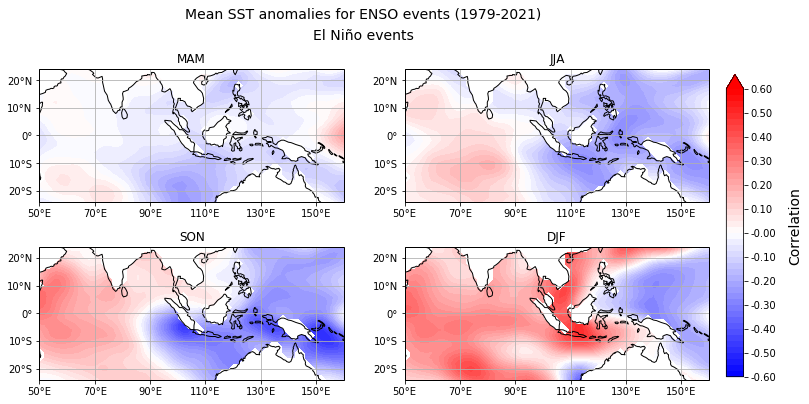

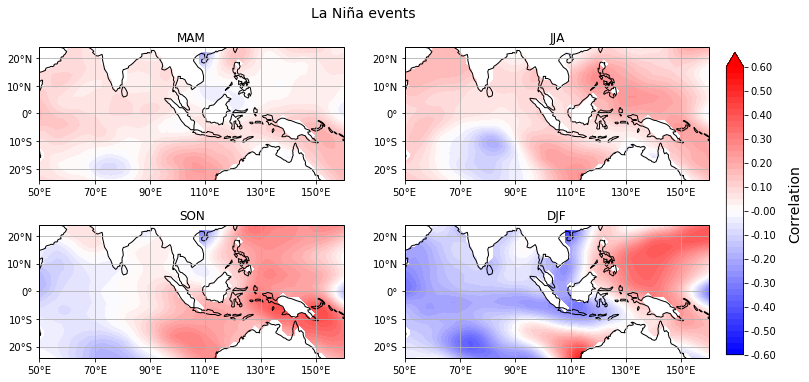

In [15]:
'''
   Plot
'''
season_name = ['MAM','JJA','SON','DJF']
cbarticks = np.arange(-0.6,0.625,0.025)

plot_latr = SSTll.latr(-25,25)
plot_lonr = SSTll.lonr(50,160)

lon2d, lat2d = np.meshgrid(SSTlons[plot_lonr[0]:plot_lonr[1]],
                           SSTlats[plot_latr[0]:plot_latr[1]])
for enso_event in range(2):
    fig = plt.figure(figsize=(12,6))

    if enso_event == 0:
        SST4_anom_mean = SST4_anom_mean_en_yrs
        fig_sub_title = 'El Niño events'
        
        title = 'Mean SST anomalies for ENSO events (1979-2021)'
        title_figs = fig.text(0.5,0.99,title,ha='center',
                             va='center',fontsize=14)
    else:
        SST4_anom_mean = SST4_anom_mean_ln_yrs
        fig_sub_title = 'La Niña events'
    
    title_individual_fig = fig.text(0.5,0.94,fig_sub_title,ha='center',
                                    va='center',fontsize=14)
    for season in range(4):
        idx_subplot = season + 1
        ax = fig.add_subplot(2,2,idx_subplot,
                             projection=ccrs.PlateCarree(central_longitude=180.0)) 

        plt.set_cmap('bwr')
        ax.coastlines(resolution='110m')
        ax.gridlines(crs = ccrs.PlateCarree(),draw_labels=False,
                     ylocs = [-25,-20,-10,0,10,20,25], xlocs=[50,70,90,110,130,150,170,180])

        #remove gridline labels from top and right side of plots
        ax.xlabels_top = False
        ax.xlabels_bottom = True
        ax.ylabels_left = True
        ax.ylabels_right = False
        #Prints out latitude and longitude with proper coordinate system
        ax.set_xticks([50,70,90,110,130,150,170], crs = ccrs.PlateCarree())
        ax.set_yticks([-20,-10,0,10,20], crs = ccrs.PlateCarree())
        lon_formatter = LongitudeFormatter()
        lat_formatter = LatitudeFormatter()
        ax.xaxis.set_major_formatter(lon_formatter)
        ax.yaxis.set_major_formatter(lat_formatter)
     

        SSTa_mean_enso_phase = np.zeros((plot_latr[1]-plot_latr[0],plot_lonr[1]-plot_lonr[0]))
        SSTa_mean_enso_phase = SST4_anom_mean[season,plot_latr[0]:plot_latr[1],
                                             plot_lonr[0]:plot_lonr[1]]
        
        #SSTa_no_nan = SSTa_mean_enso_phase[~np.isnan(SSTa_mean_enso_phase)]
        #print(np.min(SSTa_no_nan),np.max(SSTa_no_nan))
              
        shading=ax.contourf(lon2d,lat2d,SSTa_mean_enso_phase,cbarticks,
                            transform=ccrs.PlateCarree(),extend='max')
        
        #forces map to have same bounds as initially defined
        #rather than shrinking the map to the region where
        #values are using contourf
        #ctr = ax.contour(lon2d,lat2d,SST_corr_NDI_nino,cbarticks,
        #                transform=ccrs.PlateCarree())
        
        plt.title(season_name[season])

    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7]) #input: left, bottom, width, height
    cbar = fig.colorbar(shading, cax=cbar_ax, shrink = 0.8,format ='%.2f')
    cbar.set_ticks(np.arange(-0.6,0.7,0.1))
    cbarlabel = fig.text(1, 0.5, 'Correlation', ha='center',
                         va='center',rotation='vertical', fontsize = 14)

## Function for calculating seasonal SST anomaly box data

In [16]:
'''
   Function to calculate standard season SST 
   anomalies for one month and zero month lead.
   Used to calculate NDI anomaly (NDIa) 
'''
def SSTa_box_seasons(SST4_anom,year_count,latr,lonr,lead):
    SST4anom_box = np.zeros((4,year_count))
    for season in range(4):
        for year in range(year_count):
            SST4anom_box[season,year] = np.nanmean(SST4_anom[season,year,latr[0]:latr[1],
                                                             lonr[0]:lonr[1]])
            
    return SST4anom_box

## Calculate NDI anomaly (NDIa) time series values

In [17]:
'''
   ***Final NDI options reminder***
   
   1. MC box: 0°,148°E-   30w by 18h
      EP box: 0°,145°W-   50w by 10h (mirrors the Niño 3.4 region)
   
   2. MC box: 0°,148°E-   30w by 18h (Same as NDI option 1)
      EP box: 2°S,150°W-  50w by 10h
      
   3. MC box: 2°N,156°E-  30w by 18h 
      EP box: 0°,150°W-   50w by 10h
   
   4. MC box: 2°N,156°E-  30w by 18h (Same as NDI option 3)
      EP box: 2°S,154°W-  42w by 10h
      
   5. MC box: 2°S,156°E-  10w by 10h
      EP box: 2°S,158°W-  42w by 10h
      
   6. MC box: 8°N,130°E-  10w by 10h     
      EP box: 0°S,145°W-  50w by 10h
      
   Also, I am including an NDI option my former graduate school
   advisor came up with, Dr. Nielsen-Gammon.
   
   7. MC box: 0°,137°E -  86w by 6h
      EP box: 3°N,145°W - 50w by 4h
      
   I include Niño 3.4 box for testing to see if a one-box SST
   method would be improved by using an IO box. This is not
   the same as the ONI since I use a single long term mean
   here for anomaly calculations (1981-2010) rather than the
   centered 30 year means the ONI uses that shift every 5
   years.
      
   8. EP box: 0°N,145°W - 50w by 10h
   
   For exploratory purposes, I am not using the adjusted method I
   used to calculate the Niño 3.4 box with for the exact region
   bounds with. The unadjusted box calculated here extends 1° 
   longitude on the western and eastern edges (171°W-119°W),
   with the latitudinal extent matching the Niño 3.4 box definiton.

   This will make a negligible impact on the results of the
   tests.
'''

mclats = [0,0,2,2,-2,8,0]
mclons = [148,148,156,156,156,130,137]

eplats = [0,-2,0,-2,-2,-2,2]
eplons = [-145,-150,-150,-154,-158,-145,-145]

#For ERSST
mch = [8,8,8,8,4,4,2]
mcw = [14,14,14,14,4,4,43]


eph = [4,4,4,4,4,4,2]
epw = [25,24,24,20,20,25,25]

nino_ind_lat = 0
nino_ind_lon = -145
nino_ind_h = 4
nino_ind_w = 25

inds_count = 8


indices_SSTa_season = np.zeros((inds_count,2,4,nyears_gpcp))
'''
   Can structure the below for loop as...
   
   "
    for lead in range(1,-1,-1):
    ...   
   "
   
   to make the lead=1 in for loop directly correspond
   to calculating the one month standard season lead
   timeseries values for indices first. However, I want 
   to store the one month standard season lead index 
   timeseries values first for plotting and correlation 
   calculation purposes.
   
   So, lead = 0 corresponds to calculating one month lead box
   timeseries values for indices and lead = 1 corresponds to
   zero month lead box timeseries values.
'''
for lead in range(2):
    SST4_anom_loop = SST4_anom_gpcp_len[lead,:,:,:,:]
    for inds in range(inds_count):
        if inds < 7:
            mc_north = mclats[inds] + mch[inds]
            mc_south = mclats[inds] - mch[inds]
            mc_west = mclons[inds] - mcw[inds]
            mc_east = mclons[inds] + mcw[inds]
            
            mc_box_latr = SSTll.latr(mc_north,mc_south)
            mc_box_lonr = SSTll.lonr(mc_west,mc_east)
            
            mc_box_SSTa = SSTa_box_seasons(SST4_anom_loop,nyears_gpcp,
                                           mc_box_latr,mc_box_lonr,lead)
            
            ep_north = eplats[inds] + eph[inds]
            ep_south = eplats[inds] - eph[inds]
            ep_west = eplons[inds] - epw[inds]
            ep_east = eplons[inds] + epw[inds]
            
            ep_box_latr = SSTll.latr(ep_north,ep_south)
            ep_box_lonr = SSTll.lonr(ep_west,ep_east)
            
            ep_box_SSTa = SSTa_box_seasons(SST4_anom_loop,nyears_gpcp,
                                           ep_box_latr,ep_box_lonr,lead)
        
            indices_SSTa_season[inds,lead,:,:] = ep_box_SSTa - mc_box_SSTa
        else:
            idx = inds-7
            ep_north = nino_ind_lat + nino_ind_h
            ep_south = nino_ind_lat - nino_ind_h
            ep_west = nino_ind_lon - nino_ind_w
            ep_east = nino_ind_lon + nino_ind_w
            
            ep_box_latr = SSTll.latr(ep_north,ep_south)
            ep_box_lonr = SSTll.lonr(ep_west,ep_east)
            
            ep_box_SSTa = SSTa_box_seasons(SST4_anom_loop,nyears_gpcp,
                                           ep_box_latr,ep_box_lonr,lead) 
            
            indices_SSTa_season[inds,lead,:,:] = ep_box_SSTa

## Plots to evaluate best IO region to add to NDIa

C:\Users\Owner\Anaconda3\lib\site-packages\ipykernel_launcher.py:141: RuntimeWarning: Mean of empty slice


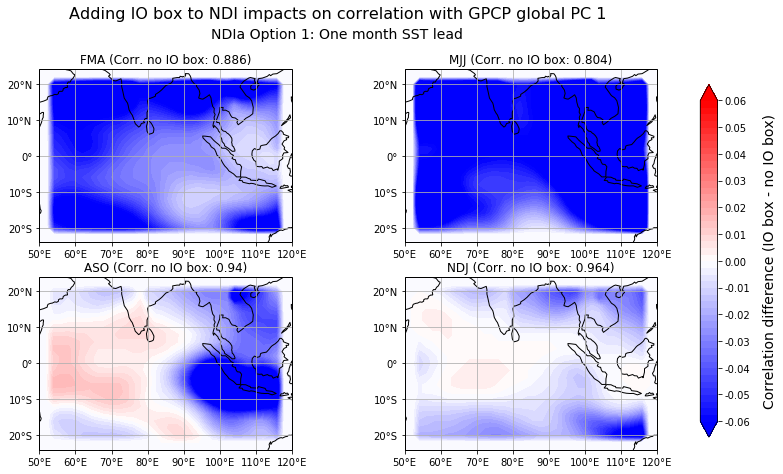

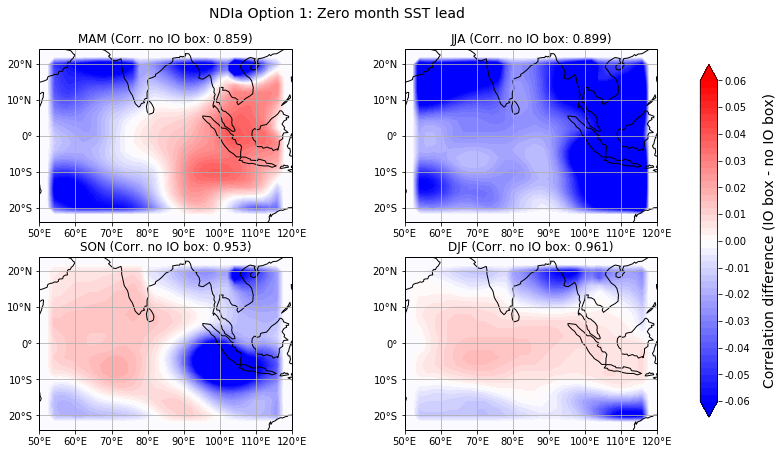

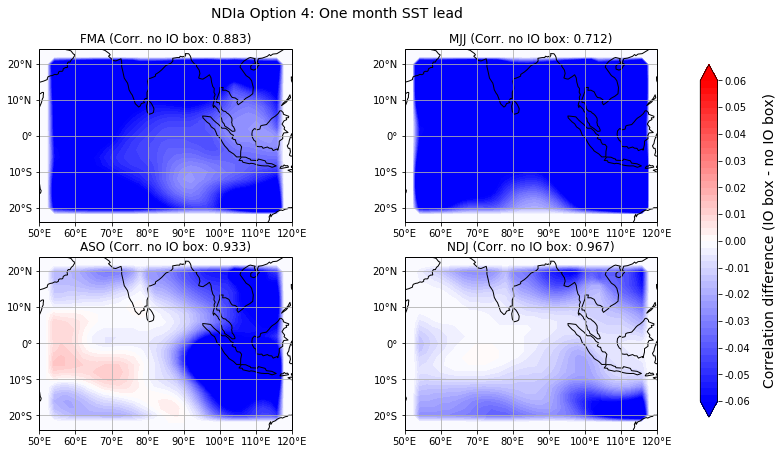

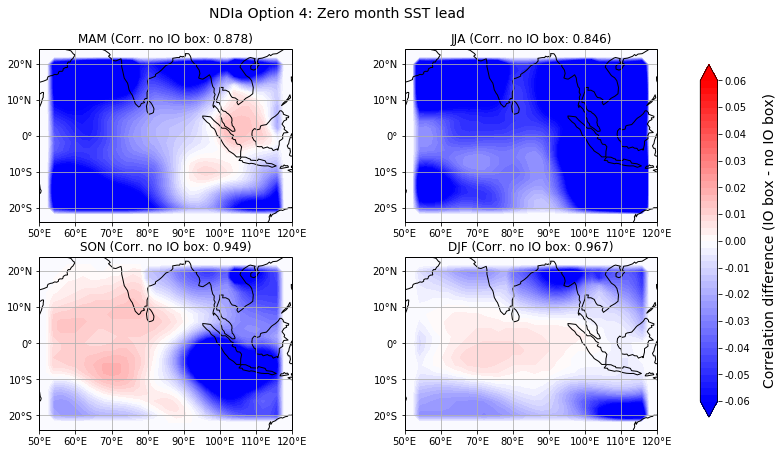

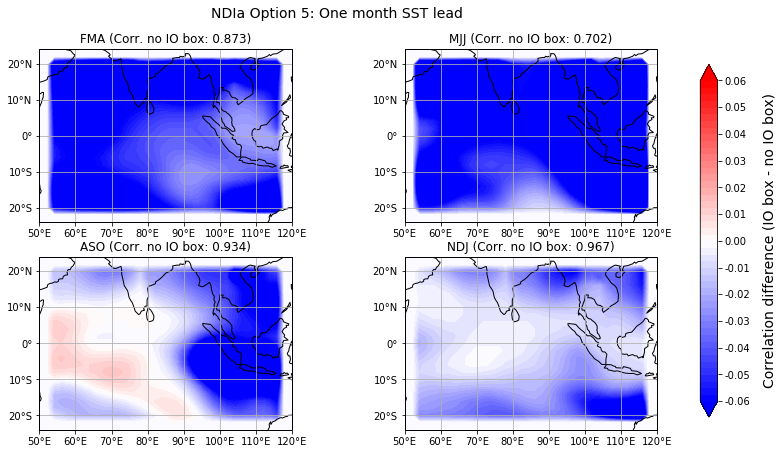

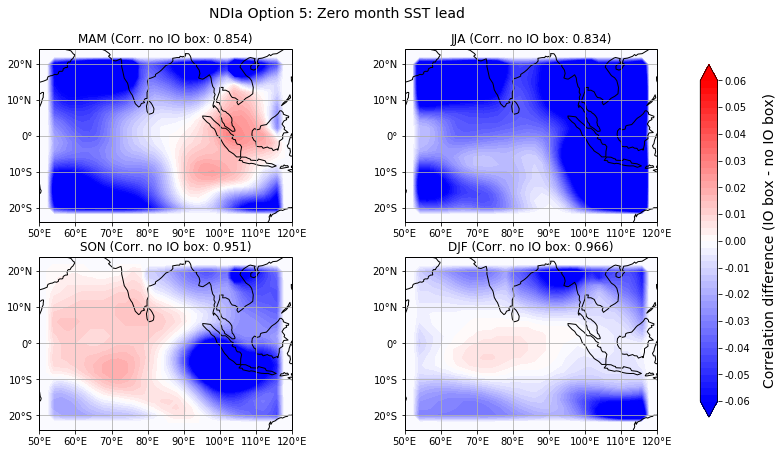

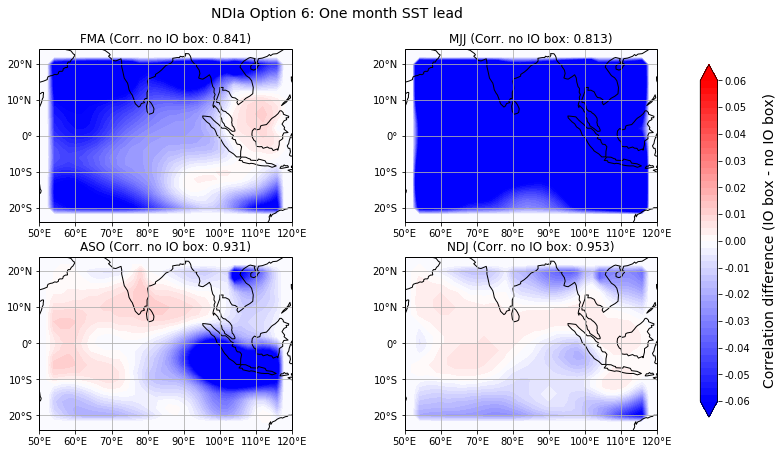

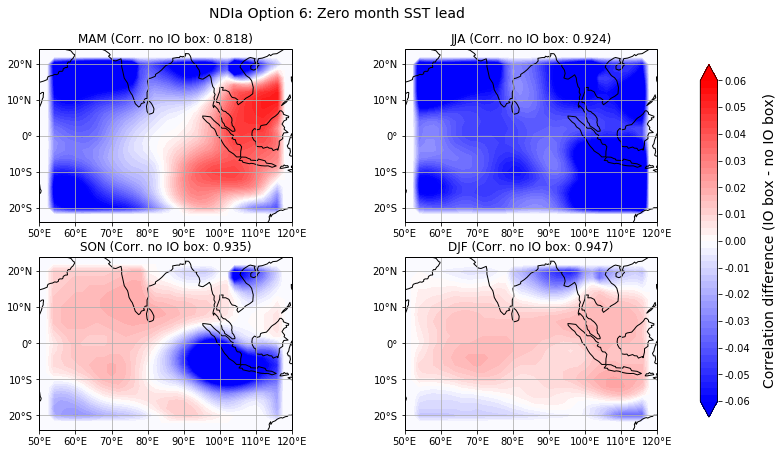

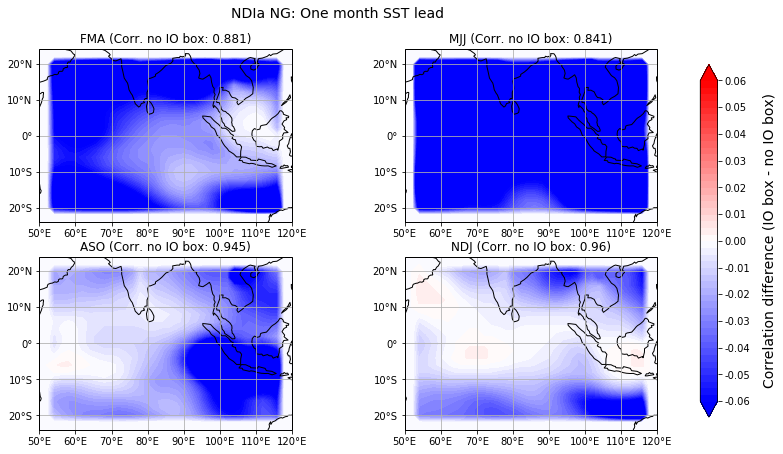

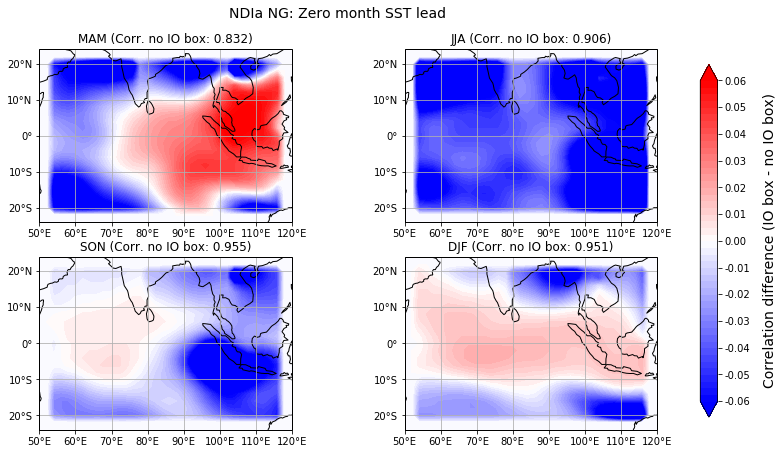

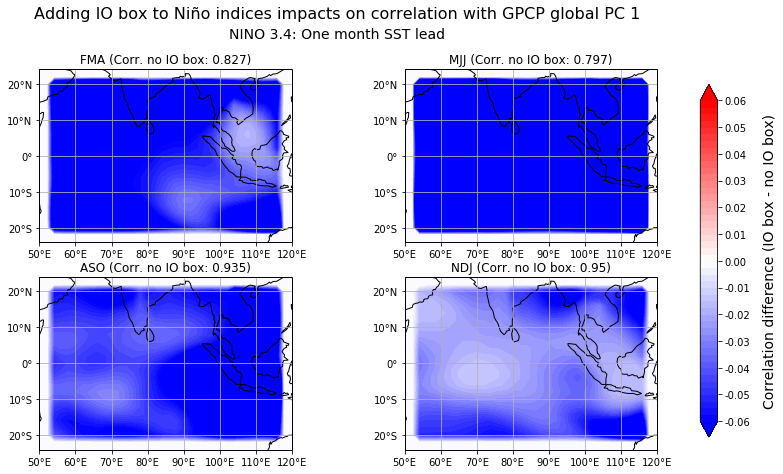

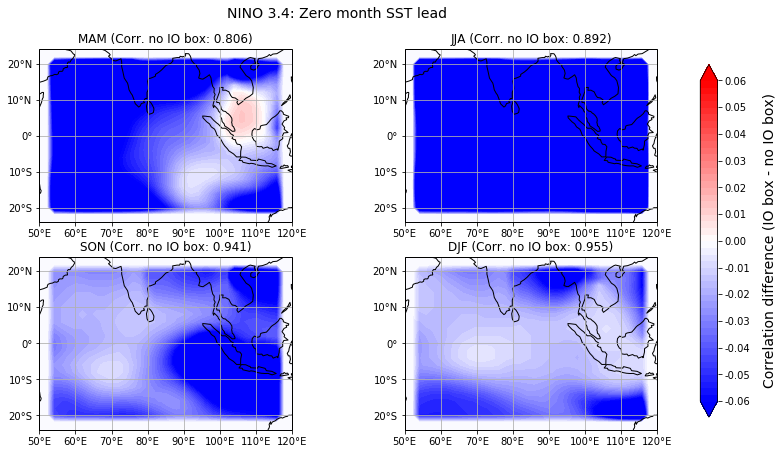

In [18]:
'''
   Calculate the correlations of the NDI options with an Indian 
   Ocean (IO box). Hold Indian Ocean box dimensions constant 
   (10° by 10°) and plot correlation for every grid point center.
   (Allow 2 degrees of freedom to vary).
   
   Also, do this for Niño 3.4 region. Choose this box size to get a 
   good flavor of what box regions the NDIa would improve upon the 
   correlations with GPCP global precipitation PC 1, the leading PC
   that captures the global response to ENSO.
   
   Plot the correlation difference, where a higher correlation indicates
   an NDIa option that would be have a stronger relationship with GPCP 
   global precipitation PC1 for a given season. Do this for four NDIa 
   options, NDIa Option 1, NDIa Option 4, NDIa Option 5, NDIa Option 6,
   and NDIa N-G. This includes all unique MC boxes from our final NDIa
   candidates (without an IO box).
   
   Indian Ocean (IO) SST region dimensions:
   Longitudes: 50°E-120°E
   Latitiudes: 25°N-25°S
   
   Since the IO region has an ENSO phase SST anomaly response that matches 
   the Niño region response, the box needs to be added to the original NDIa.
   
   Thus, the NDIa with an IO box would become:
   NDIa = EP box SSTa - MC box SSTa + IO box SSTa
   
   Set colorbar maximum based on the maximum correlation for all plots
'''

#region bounds
io_latr = SSTll.latr(-25,25)
io_north = SSTlats[io_latr[0]]
#Add 2 since it finds first latitude value
#past bounds for indexing purposes
io_south = SSTlats[io_latr[1]] + 2

io_lonr = SSTll.lonr(50,120)
io_west = SSTlons[io_lonr[0]]
io_east = SSTlons[io_lonr[1]] - 2

#1/2 heights
io_h = 4
io_w = 4

lon2d, lat2d = np.meshgrid(SSTlons[io_lonr[0]:io_lonr[1]],
                           SSTlats[io_latr[0]:io_latr[1]])

cbarticks = np.arange(-0.06,0.0625,0.0025)

#throw zero and month lead season NDI options
#into single array for loop

#Do for NDIa option 1,4,5,6, NDIa N-G, NDIa with Nino 3 box, Nino 3.4 box
#Indian ocean 2 df test for all unique MC box options
inds_retrieval = [0,3,4,5,6,7]
inds_count_test = 6
inds_io_box_test = np.zeros((inds_count_test,2,4,nyears_gpcp))
#ENSO_indices = [NDIa_ng,NDIa_opt_4,NDIa_opt_5,NDIa_opt_1,ONI_SSTa,NDIa_w_NINO3,NINO3_SSTa]
for inds in range(inds_count_test):
    idx = inds_retrieval[inds]
    inds_io_box_test[inds,:,:,:] = indices_SSTa_season[idx,:,:,:]

plot_desc_label = 'Adding IO box to NDI impacts on correlation with GPCP global PC 1'
plot_desc_label_2 = 'Adding IO box to Niño indices impacts on correlation with GPCP global PC 1'
leads_label = ['One month SST lead','Zero month SST lead']
#ENSO_ind_label = ['NDIa N-G','NDIa Option 4','NDIa Option 5','NDIa Option 1','ONI','NDIa with NINO3 EP box','NINO3']
ENSO_ind_label = ['NDIa Option 1','NDIa Option 4','NDIa Option 5','NDIa Option 6','NDIa NG',
                  'NINO 3.4']

cmin_loop = 0
cmax_loop = 0

for ind in range(inds_count_test):
    ENSO_ind = inds_io_box_test[ind,:,:,:]
    for lead in range(2):
        fig = plt.figure(figsize=(12,7))
        #arrays to be used in season loop
        ENSO_ind_loop = ENSO_ind[lead,:,:]
        SST4a_loop = SST4_anom_gpcp_len[lead,:,:,:,:]
        #plotting figure titles
        title = ENSO_ind_label[ind] + ': ' + leads_label[lead]
        fig_label = fig.text(0.5,0.95,title,ha='center',
                            va='center',fontsize=14)
        
        if ind == 0 and lead == 0:
            figs_superlabel = fig.text(0.5,0.99,plot_desc_label,ha='center',
                                       va='center',fontsize=16)
        elif ind == 5 and lead == 0:
            figs_superlabel = fig.text(0.5,0.99,plot_desc_label_2,ha='center',
                                       va='center',fontsize=16)
        #subplot season labels
        if lead == 0:
            season_labels = ['FMA','MJJ','ASO','NDJ']
        else:
            season_labels = ['MAM','JJA','SON','DJF']
        for season in range(4):
            c_base = 0
            c_base = np.round(np.corrcoef(ENSO_ind_loop[season,:],GPCP_global_pc1[season,:])[0,1],3)
            
            idx_subplot = season + 1    
            ax = fig.add_subplot(2,2,idx_subplot,
                                 projection=ccrs.PlateCarree(central_longitude=180.0)) 
            plt.set_cmap('bwr')
            ax.coastlines(resolution='110m')
            ax.gridlines(crs = ccrs.PlateCarree(),draw_labels=False,
                         ylocs = [-25,-20,-10,0,10,20,25], xlocs=[50,60,70,80,90,100,110,120])

            #remove gridline labels from top and right side of plots
            ax.xlabels_top = False
            ax.xlabels_bottom = True
            ax.ylabels_left = True
            ax.ylabels_right = False
            #Prints out latitude and longitude with proper coordinate system
            ax.set_xticks([50,60,70,80,90,100,110,120], crs = ccrs.PlateCarree())
            ax.set_yticks([-20,-10,0,10,20], crs = ccrs.PlateCarree())
            lon_formatter = LongitudeFormatter()
            lat_formatter = LatitudeFormatter()
            ax.xaxis.set_major_formatter(lon_formatter)
            ax.yaxis.set_major_formatter(lat_formatter)
        
            c_diff_plot = np.zeros((io_latr[1]-io_latr[0],
                                    io_lonr[1]-io_lonr[0]))
        
            for lat in range(io_latr[0],io_latr[1]):
                io_lat_c = SSTlats[lat]
                io_lat_s = io_lat_c - io_h
                io_lat_n = io_lat_c + io_h
                io_box_latr = SSTll.latr(io_lat_s,io_lat_n)
                for lon in range(io_lonr[0],io_lonr[1]):
                    io_lon_c = SSTlons[lon]
                    io_lon_w = io_lon_c - io_w
                    io_lon_e = io_lon_c + io_w
                    io_box_lonr = SSTll.lonr(io_lon_w,io_lon_e)
                    SSTa_io_box = np.zeros(nyears_gpcp,)
                
                    for year in range(nyears_gpcp):
                        SSTa_io_box[year] = np.nanmean(SST4a_loop[season,year,
                                                                 io_box_latr[0]:io_box_latr[1],
                                                                 io_box_lonr[0]:io_box_lonr[1]])
                
                    ENSO_ind_w_io = ENSO_ind_loop[season,:] + SSTa_io_box
                    c_ENSO_ind_w_io = 0
                    c_diff = 0
                    #to filter IO boxes that do not fully fit within
                    #defined IO region
                    if io_lat_n > io_north or io_lat_s < io_south:
                        c_diff = 0
                    elif io_lon_w < io_west or io_lon_e > io_east:
                        c_diff = 0
                    else:
                        c_ENSO_ind_w_io = np.round(np.corrcoef(ENSO_ind_w_io,GPCP_global_pc1[season,:])[0,1],3)
                        c_diff = np.round(c_ENSO_ind_w_io - c_base,3)
                    
                    lat_store = lat - io_latr[0]
                    lon_store = lon - io_lonr[0]
                    c_diff_plot[lat_store,lon_store] = c_diff
            
            #used to find max and min
            #correlations of all data
            #plotted to set colobar
            #range.
            cmin = np.min(c_diff_plot)
            cmax = np.max(c_diff_plot)
            if cmin < cmin_loop:
                cmin_loop = cmin
            elif cmax > cmax_loop:
                cmax_loop = cmax
              
            shading=ax.contourf(lon2d,lat2d,c_diff_plot,cbarticks,
                                transform=ccrs.PlateCarree(),extend='both')
        
            #forces map to have same bounds as initially defined
            #rather than shrinking the map to the region where
            #values are using contourf
            #ctr = ax.contour(lon2d,lat2d,SST_corr_NDI_nino,cbarticks,
            #                transform=ccrs.PlateCarree())
        
            plt.title(season_labels[season]+' '+'('+'Corr. no IO box:'+' '+str(c_base)+')')

        cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7]) #input: left, bottom, width, height
        cbar = fig.colorbar(shading, cax=cbar_ax, shrink = 0.8,format ='%.2f')
        cbar.set_ticks(np.arange(-0.07,0.08,0.01))
        cbarlabel = fig.text(1, 0.5, 'Correlation difference (IO box - no IO box)', ha='center',
                             va='center',rotation='vertical', fontsize = 14) 

In [19]:
'''
   Absolute correlation max and min
   values used to set colorbar range
   in above cell.
   
   Tailor the colorbar range to the
   maximum since I am interested in
   regions where the correlation 
   strength increases.
'''
print('Correlation min:',cmin_loop)
print('Correlation max:',cmax_loop)

Correlation min: -0.321
Correlation max: 0.064


## Add IO box to NDIa for correlation test with GPCP global PC 1

In [20]:
'''
   IO box 1 for all options except for NDI N-G,
   which uses slightly different IO box.
   
   The preferred IO boxes from the above test
   aligns closely to the STIO region from Liu
   et al. 2019.
   
   Also, note that the Niño 3.4 region does not 
   improve with using any IO box from the above 
   plots.
'''

io_box_1_latr = SSTll.latr(-2,-10)
io_box_1_lonr = SSTll.lonr(66,72)

io_box_2_latr = SSTll.latr(0,-8)
io_box_2_lonr = SSTll.lonr(66,72)

SSTa_io_box_1 = np.zeros((2,4,nyears_gpcp))
SSTa_io_box_2 = np.zeros((2,4,nyears_gpcp))

for leads in range(2):
    SST4_anom_loop = SST4_anom_gpcp_len[leads,:,:,:,:]
    SSTa_io_box_1[leads,:,:] = SSTa_box_seasons(SST4_anom_loop,nyears_gpcp,
                                                     io_box_1_latr,io_box_1_lonr,leads)
    SSTa_io_box_2[leads,:,:] = SSTa_box_seasons(SST4_anom_loop,nyears_gpcp,
                                                     io_box_2_latr,io_box_2_lonr,leads)

NDIa_count = 7
NDIa_with_io = np.zeros((NDIa_count,2,4,nyears_gpcp))
for ind in range(NDIa_count):
    if ind != 6:
        NDIa_with_io[ind,:,:,:] = indices_SSTa_season[ind,:,:,:] + SSTa_io_box_1
    else:
        NDIa_with_io[ind,:,:,:] = indices_SSTa_season[ind,:,:,:] + SSTa_io_box_2

In [21]:
'''
   Correlation calculations for lead and no lead.
   Do for NDIa without IO box and NDIa with IO box
   to see differences in correlation.
'''
corr_lead = np.zeros((2,NDIa_count,4))
corr_no_lead = np.zeros((2,NDIa_count,4))

for ndi_type in range(2):
    if ndi_type == 0:
        NDIa_type = indices_SSTa_season
    else:
        NDIa_type = NDIa_with_io
    for ndi in range(NDIa_count):
        NDIa_loop = NDIa_type[ndi,:,:,:]
        for leads in range(2):
            for season in range(4):
                if leads == 0:
                    corr_lead[ndi_type,ndi,season] = np.round(np.corrcoef(NDIa_loop[leads,
                                                                                season,:],GPCP_global_pc1[season,:])[0,1],3)
                else:
                    corr_no_lead[ndi_type,ndi,season] = np.round(np.corrcoef(NDIa_loop[leads,
                                                                                   season,:],GPCP_global_pc1[season,:])[0,1],3)

In [22]:
'''Print correlations with pandas'''

NDIa_labels = ['NDIa 1','NDIa 2','NDIa 3','NDIa 4','NDIa 5','NDIa 6','NDIa NG']
NDIa_io_labels = ['NDIa 1 IO','NDIa 2 IO','NDIa 3 IO','NDIa 4 IO','NDIa 5 IO','NDIa 6 IO','NDIa NG IO']

lead_labels = ['FMA','MJJ','ASO','NDJ']
no_lead_labels = ['MAM','JJA','SON','DJF']

c_store = [corr_lead,corr_no_lead]

headers_1 = ['One month SST lead','No SST lead']
headers_2 = ['NDIa (EP-MC)','NDIa + IO box']
space = ['          ','            ']
space_2 = ['            ','            ']
print('     '+'\033[1m'+'======|GPCP Global PC1|======'+'\033[0m')
for leads in range(2):
    print(space[leads]+'\033[1m'+headers_1[leads]+'\033[0m')
    c_loop = c_store[leads]
    for ndi_type in range(2):
        print(space_2[ndi_type]+'\033[1m'+headers_2[ndi_type]+'\033[0m','\n')
        c_print = c_loop[ndi_type,:,:]
        if leads == 0:
            season_labels = lead_labels
        else:
            season_labels = no_lead_labels
        
        c_df = pd.DataFrame(c_print)
        c_df.index = NDIa_labels
        c_df.columns = season_labels
        pd.set_option("display.colheader_justify","center")
        print(c_df,"\n")

     ======|GPCP Global PC1|======
          One month SST lead
            NDIa (EP-MC) 

          FMA    MJJ    ASO    NDJ 
NDIa 1   0.886  0.804  0.940  0.964
NDIa 2   0.877  0.773  0.941  0.965
NDIa 3   0.892  0.757  0.930  0.966
NDIa 4   0.883  0.712  0.933  0.967
NDIa 5   0.873  0.702  0.934  0.967
NDIa 6   0.841  0.813  0.931  0.953
NDIa NG  0.881  0.841  0.945  0.960 

            NDIa + IO box 

          FMA    MJJ    ASO    NDJ 
NDIa 1   0.850  0.753  0.953  0.968
NDIa 2   0.835  0.713  0.952  0.968
NDIa 3   0.846  0.699  0.945  0.968
NDIa 4   0.829  0.645  0.943  0.967
NDIa 5   0.819  0.652  0.946  0.965
NDIa 6   0.810  0.735  0.936  0.960
NDIa NG  0.838  0.761  0.941  0.963 

            No SST lead
            NDIa (EP-MC) 

          MAM    JJA    SON    DJF 
NDIa 1   0.859  0.899  0.953  0.961
NDIa 2   0.856  0.884  0.953  0.964
NDIa 3   0.879  0.867  0.946  0.963
NDIa 4   0.878  0.846  0.949  0.967
NDIa 5   0.854  0.834  0.951  0.966
NDIa 6   0.818  0.924  0.935  0.94

## Search for best IO box using four degrees of freedom

In [23]:
'''
   The above correlation tests indicate that
   the NDIa with an IO box performs better in
   ASO/SON and NDJ/DJF, the season where ENSO events
   mature and are fully mature. The strongest
   ENSO impacts are seen in DJF. This is promising,
   even though correlation strength decreases
   in FMA/MAM and MJJ/JJA. However, since in those
   seasons ENSO events are typically decaying or
   in an ENSO neutral state, it's a potentially
   acceptable trade-off. 
   
   Below is a four degrees of freedom test that would
   add the most optimal IO box to all NDIa options.
   Perform for SON and DJF seasons since that is where
   uniform improvement is seen using an IO box for the
   above search using GPCP global precipitation PC 1. 
   
   Min box width:  10 (east-west extent)
   Max box height: 10 (north-south extent)
   Max box width:  26 
   Max box height: 26 
   
   The below IO box height/width arrays stores the
   index value for each 1/2 height/width to use in 
   for loops
   
   Note: I already did this test with a box minimum
   height and width of 5 and the preferred boxes
   were all those dimensions. They also laid within
   or very close to the bounds of the chosen IO boxes
   for the NDIa with the search above. I want to see
   what the best IO boxes are setting the minimum
   box size as the IO box size used in the above 
   search. 
   

'''
#region bounds
io_latr = SSTll.latr(-25,25)
io_north = SSTlats[io_latr[0]]
#Add 2 since it finds first latitude value
#past bounds for indexing purposes
io_south = SSTlats[io_latr[1]] + 2

io_lonr = SSTll.lonr(50,120)
io_west = SSTlons[io_lonr[0]]
io_east = SSTlons[io_lonr[1]] - 2

ioh_max = np.zeros(io_latr[1]-io_latr[0],)
#max 1/2 height
ioh_abs_max = 12
for iolat in range(io_latr[0],io_latr[1]):
    idx = iolat - io_latr[0]
    iolat_loop = SSTlats[iolat]
    ioh_max1 = io_north - iolat_loop
    ioh_max2 = abs(io_south) + iolat_loop
    ioh_max_val = min(ioh_max1,ioh_max2)
    #limit IO height to 26° (north-south extent)
    if ioh_max_val < 13:
        ioh_max[idx] = ioh_max_val/2
    else:
        ioh_max[idx] = ioh_abs_max/2

ioh_max = ioh_max.astype(int)

iow_max = np.zeros(io_lonr[1]-io_lonr[0],)
iow_abs_max = 12
for iolon in range(io_lonr[0],io_lonr[1]):
    idx = iolon - io_lonr[0]
    iolon_loop = SSTlons[iolon]
    iow_max1 = abs(io_west - iolon_loop)
    iow_max2 = io_east - iolon_loop
    iow_max_val = int(min(iow_max1,iow_max2))
    #limit IO box width to 26° (east-west extent)
    if iow_max_val < 13:
        iow_max[idx] = int(iow_max_val/2)
    else:
        iow_max[idx] = 12/2
        
iow_max = iow_max.astype(int)

#Set minimum box size to 
#10 deg by 10 deg
ioh_min_loop = 2
iow_min_loop = 2

In [24]:
'''
   Create an empty list to store
   MC box grid point/dimension
   information and correlations.
   
   Rows: MC box information +
         correlation value
         
   Columns: Case number
   
   First 7 rows will be for SON
   and last 7 rows will be for DJF
'''
NDIa_best_io_info_seasons = []

for rows in range(NDIa_count*2):
    column_list = []
    for columns in range(6):
        column_list.append(0)
        
    NDIa_best_io_info_seasons.append(column_list)

In [25]:
'''
   Need to change SST_loop value for IO box calculations
   and I need to make an empty list to print values into
'''

for ndi in range(NDIa_count):
    #First if/else statement for test of SON NDI with SON 
    #and DJF of GPCP global PC 1
    NDIa_opt_loop = indices_SSTa_season[ndi,:,:,:]
    for season in range(2):
        #extract SON and DJF anomaly 
        #time-series values
        season_idx = season+2
        NDIa_season = NDIa_opt_loop[1,season_idx,:]
        #set "corr_max" variable to use at 
        #end of loops
        corr_max = 0
        for iolat in range(io_latr[0],io_latr[1]):
            iolat_loop = SSTlats[iolat]
            idx = iolat - io_latr[0]
            ioh_max_loop = ioh_max[idx]
            for iolon in range(io_lonr[0],io_lonr[1]):
                iolon_loop = SSTlons[iolon]
                idx = iolon - io_lonr[0]
                iow_max_loop = iow_max[idx]
                for ioh in range(ioh_min_loop,ioh_max_loop+1):
                    #adjust height since it based off of gridpoint
                    #indexing
                    ioh_loop = ioh*2
                    #find southern/northern boundary of MC box
                    #multiply by lat/lon grid spacing (2 degrees)
                    #to find half height value
                    iobox_n = iolat_loop + ioh_loop
                    iobox_s = iolat_loop - ioh_loop
                    iobox_latr = SSTll.latr(iobox_s,iobox_n)
              
                    for iow in range(iow_min_loop,iow_max_loop+1):
                        iow_loop = iow*2
                        #find eastern and eastern/boundary of MC box
                        iobox_w = iolon_loop - iow_loop
                        iobox_e = iolon_loop + iow_loop
                        iobox_lonr = SSTll.lonr(iobox_w,iobox_e)

                        io_box_data = np.zeros((nyears_gpcp,)) 
                        for year in range(nyears_gpcp):
                            io_box_data[year] = np.nanmean(SST4_anom_gpcp_len[1,season_idx,year,
                                                                              iobox_latr[0]:iobox_latr[1],
                                                                              iobox_lonr[0]:iobox_lonr[1]])
                    
                        corr = 0
                        #omitting calculations of NDI for MC 
                        #boxes that fully cover land regions
                        if np.isnan(io_box_data[0]) == False:   
                            NDIa_io = NDIa_season + io_box_data                                     
                            corr = np.round(np.corrcoef(NDIa_io,GPCP_global_pc1[season_idx,:])[0,1],3)
                        
                        if corr > corr_max and season == 0:
                            NDIa_type = NDIa_labels[ndi] + str(' w/ IO box SON')
                            #store values
                            NDIa_best_io_info_seasons[ndi][0] = NDIa_type
                            NDIa_best_io_info_seasons[ndi][1] = iolat_loop
                            NDIa_best_io_info_seasons[ndi][2] = iolon_loop
                            NDIa_best_io_info_seasons[ndi][3] = ioh_loop
                            NDIa_best_io_info_seasons[ndi][4] = iow_loop
                            NDIa_best_io_info_seasons[ndi][5] = corr
                            #set new max correlation value
                            corr_max = corr
                        elif corr > corr_max and season == 1:
                            NDIa_type = NDIa_labels[ndi] + str(' w/ IO box DJF')
                            #store values
                            NDIa_best_io_info_seasons[ndi+NDIa_count][0] = NDIa_type
                            NDIa_best_io_info_seasons[ndi+NDIa_count][1] = iolat_loop
                            NDIa_best_io_info_seasons[ndi+NDIa_count][2] = iolon_loop
                            NDIa_best_io_info_seasons[ndi+NDIa_count][3] = ioh_loop
                            NDIa_best_io_info_seasons[ndi+NDIa_count][4] = iow_loop
                            NDIa_best_io_info_seasons[ndi+NDIa_count][5] = corr
                            #set new max correlation value
                            corr_max = corr
                        else:
                            continue

## Print best IO box coordinates + correlation from above search 

In [26]:
for ndi in range(NDIa_count*2):
    print(NDIa_best_io_info_seasons[ndi])

['NDIa 1 w/ IO box SON', -6.0, 70.0, 4, 4, 0.972]
['NDIa 2 w/ IO box SON', -6.0, 70.0, 4, 4, 0.973]
['NDIa 3 w/ IO box SON', -6.0, 70.0, 4, 4, 0.968]
['NDIa 4 w/ IO box SON', -8.0, 70.0, 4, 4, 0.968]
['NDIa 5 w/ IO box SON', -6.0, 72.0, 4, 4, 0.971]
['NDIa 6 w/ IO box SON', 16.0, 76.0, 6, 4, 0.955]
['NDIa NG w/ IO box SON', 4.0, 70.0, 12, 4, 0.963]
['NDIa 1 w/ IO box DJF', -4.0, 68.0, 4, 4, 0.977]
['NDIa 2 w/ IO box DJF', -4.0, 70.0, 4, 4, 0.978]
['NDIa 3 w/ IO box DJF', -2.0, 70.0, 4, 4, 0.977]
['NDIa 4 w/ IO box DJF', -4.0, 70.0, 4, 4, 0.977]
['NDIa 5 w/ IO box DJF', -4.0, 72.0, 4, 4, 0.974]
['NDIa 6 w/ IO box DJF', -6.0, 108.0, 12, 4, 0.97]
['NDIa NG w/ IO box DJF', -4.0, 70.0, 4, 4, 0.971]


## Correlation tests for NDIa Option 6 + IO box and interpretation of above search

In [27]:
'''
    The four degrees of freedom test shows that the NDIa options prefer the same region as 
    the two degrees of freedom test. However, NDIa option 6 prefers a box in a different 
    part of the Indian Ocean. Print correlation tests using best SON and DJF box.
    It's worth noting that this is the only box that was chosen with an non-tropical 
    response to ENSO (selected using Northern Hemisphere and non-tropical PC 1 in two 
    degrees of freedom search from NDI_options_search). As a result, it is reasonable 
    that the best IO box option is different than the other options.
'''

io_box_option = 2
NDIa_opt_6_best_io = np.zeros((io_box_option,2,4,nyears_gpcp))

for io_box_opt in range(2):
    if io_box_opt == 0:
        io_box_ind = 5
    else:
        io_box_ind = 5 + NDIa_count
    for leads in range(2):
        SST4_anom_loop = SST4_anom_gpcp_len[leads,:,:,:,:]
        NDIa_opt_6 = indices_SSTa_season[5,leads,:,:]
        io_lat = NDIa_best_io_info_seasons[io_box_ind][1]
        io_lon = NDIa_best_io_info_seasons[io_box_ind][2]
        ioh = NDIa_best_io_info_seasons[io_box_ind][3]
        iow = NDIa_best_io_info_seasons[io_box_ind][4]
        io_box_latr = SSTll.latr(io_lat+ioh,io_lat-ioh)
        io_box_lonr = SSTll.lonr(io_lon+iow,io_lon-iow)
    
        io_box_mean = SSTa_box_seasons(SST4_anom_loop,nyears_gpcp,
                                       io_box_latr,io_box_lonr,leads)
    
        NDIa_opt_6_best_io[io_box_opt,leads,:,:] = NDIa_opt_6 + io_box_mean
    

corr_compare_lead = np.zeros((3,4))
corr_compare_no_lead = np.zeros((3,4))

for io_box_opt in range(2):
    idx_store = io_box_opt + 1
    for lead in range(2):
        for season in range(4):
            if lead == 0:
                corr_compare_lead[idx_store,season] = np.round(np.corrcoef(NDIa_opt_6_best_io[io_box_opt,lead,season,:],
                                                               GPCP_global_pc1[season,:])[0,1],3)
            else:
                corr_compare_no_lead[idx_store,season] = np.round(np.corrcoef(NDIa_opt_6_best_io[io_box_opt,lead,season,:],
                                                                  GPCP_global_pc1[season,:])[0,1],3)

'''Import correlations using IO box from 2 degrees of freedom method with 10w by 10h box'''
corr_compare_lead[0,:] = corr_lead[1,5,:]
corr_compare_no_lead[0,:] = corr_no_lead[1,5,:]

In [28]:
'''
   The IO boxes from the 4 degrees of freedom search does not provide an improvement upon
   the best IO box found from the 2 degrees of freedom search. Thus, elect to use
   the box found from 2 degrees of freedom search for further testing instead.
'''

NDIa_labels = ['NDIa Opt 6 + IO (2 df)','NDIa Opt 6 + IO (4 df)','NDIa Opt 6 + IO (4 df)']
lead_labels = ['FMA','MJJ','ASO','NDJ']
no_lead_labels = ['MAM','JJA','SON','DJF']

print('           '+'\033[1m'+'======|GPCP global PC 1|======'+'\033[0m','\n')
for c_type in range(2):
    if c_type == 0:
        corr = corr_compare_lead
        season_labels = lead_labels
    else:
        corr = corr_compare_no_lead
        season_labels = no_lead_labels
        
    c_df = pd.DataFrame(corr)
    c_df.index = NDIa_labels
    c_df.columns = season_labels
    pd.set_option("display.colheader_justify","center")
    print(c_df,"\n")

           ======|GPCP global PC 1|====== 

                         FMA    MJJ    ASO    NDJ 
NDIa Opt 6 + IO (2 df)  0.810  0.735  0.936  0.960
NDIa Opt 6 + IO (4 df)  0.773  0.702  0.940  0.953
NDIa Opt 6 + IO (4 df)  0.850  0.693  0.898  0.962 

                         MAM    JJA    SON    DJF 
NDIa Opt 6 + IO (2 df)  0.798  0.888  0.953  0.965
NDIa Opt 6 + IO (4 df)  0.759  0.864  0.955  0.953
NDIa Opt 6 + IO (4 df)  0.866  0.861  0.916  0.970 



# Graphic displaying proposed NDIa Option 1 box locations

C:\Users\Owner\Anaconda3\lib\site-packages\matplotlib\legend.py:1270: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  warnings.warn("You have mixed positional and keyword arguments, some "


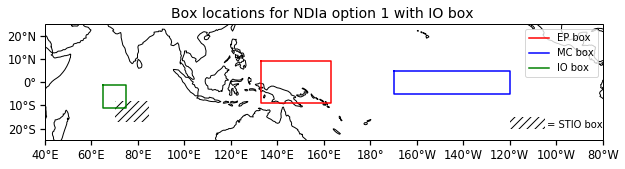

In [29]:
'''
   Plot NDIa Option 1 + IO box 
   (EP, MC and IO box locations).
   
   Since all NDIa options have the same
   IO box (minus NDIa N-G, which uses
   slightly different box), plot NDIa
   Option 1 as an example.
   
   Also shading the region where the STIO
   box is from Liu et al. 2019 to demonstrate
   the how close the proposed IO box for the 
   NDIa is to that region (paper mentioned
   in the intro for this jupyter notebook
   in the first cell).
'''
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1,
                     projection=ccrs.PlateCarree(central_longitude=180.0))

ax.coastlines(resolution='110m')
ax.set_extent([40,280,-25,25], crs=ccrs.PlateCarree())
#Latitude (Longitude) labels on left (bottom) of figure
ax.xlabels_top = False
ax.xlabels_bottom = True
ax.ylabels_left = True
ax.ylabels_right = False
ax.set_xticks([40,60,80,100,120,140,160,180,-160,-140,-120,-100,-80],crs = ccrs.PlateCarree())

ax.set_yticks([-20,-10,0,10,20], crs = ccrs.PlateCarree())
lon_formatter = LongitudeFormatter()
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)

#Make tickmark and tick labels larger
#for improved readability
ax.tick_params(axis='both',labelsize=11.5)
ax.tick_params(width=1.25,length=5)

'''MC box'''
mcbox_lons = [-47,-17,-17,-47,-47]
mcbox_lats = [9,9,-9,-9,9]
mcbox = ax.plot(mcbox_lons,mcbox_lats,color='r',linestyle = 'solid')

'''EP box'''
epbox_lons = [10,60,60,10,10]
epbox_lats = [5,5,-5,-5,5]
epbox = ax.plot(epbox_lons,epbox_lats,color='b',linestyle = 'solid')

'''IO box'''
iobox_lons = [-115,-105,-105,-115,-115]
iobox_lats = [-1,-1,-11,-11,-1]
iobox = ax.plot(iobox_lons,iobox_lats,color='g',linestyle = 'solid')

#io_box_1_latr = SSTll.latr(-2,-10)
#io_box_1_lonr = SSTll.lonr(66,72)


ax.add_patch(Rectangle((-110, -17), 15, 9,fill=False,hatch='///',linewidth=0))
ax.add_patch(Rectangle((60,-20),15,5,fill=False,hatch='///',linewidth=0))
ax.text(76,-19.5,'= STIO box')

legend_labels = ['EP box','MC box','IO box']
title = 'Box locations for NDIa option 1 with IO box'
header = fig.text(0.51,0.66,title, ha='center', va='center',fontsize = 14)
leg = ax.legend([mcbox,epbox,iobox],loc=1, labels=legend_labels,fontsize = 10)

## Further correlation tests with NDIa in comparison to NDIa with IO box

In [30]:
'''
   Read in to calculate GPCP lat/lon object
   for indexing bounds to find regional PC 
   time series. Used for correlation tests.
'''

GPCP_nc = Dataset(GPCP,'r')

'''Load in GPCP data variables'''
GPCPlats = GPCP_nc.variables['lat'][:]
GPCPlons = GPCP_nc.variables['lon'][:]
GPCPtime = GPCP_nc.variables['time'][:]
precip = GPCP_nc.variables['precip'][:]  # shape is time, lat, lon as shown above
GPCPdtime = num2date(GPCP_nc.variables['time'][:],GPCP_nc.variables['time'].units)
GPCPll = LatLon(GPCPlats[0],GPCPlats[1]-GPCPlats[0],
                GPCP_nc.variables['lat'].size,
                GPCPlons[0],GPCPlons[1]-GPCPlons[0],
                GPCP_nc.variables['lon'].size)

In [31]:
'''
   Load precipArea (GPCP data) that weights precipitation based
   on area of grid box since 1x1 degree box (latitude/longitude)
   of rainfall in tropics much larger than in the poles)
   
'''

filename_precipArea = ENSOdir + str("GPCP\\precipArea_PC_calcs.npy")
precipArea = np.load(filename_precipArea)

In [32]:
'''
   Principal component analysis function that finds the spatial variability map of 
   data for each mode and the corresponding principal component (PC) time series for 
   the leading modes of variability. Leading PC time series of precipitation data used 
   in box search process since ENSO is the leading mode of climate variability.
'''

def EOFanalysis(data,nyears):
    #creating arrays to store values
    pca = []
    pcaTS = []
    pca_expv = np.zeros((4,4)) #np array is (number of seasons) x (top 4 PC explained variance)
    pca_amp = np.zeros((4,4))
    pca_spat_var = []
    for season in range(4):
        if data.ndim == 4:
            X = np.reshape(data[season,:,:,:],
                           (nyears,-1)) #PCA only works on 2-d arrays. Throw lat/lon into 1-d
        else:
            X = np.reshape(data[season,:,:],
                          (nyears,-1))
            
        pca1 = PCA()
        pca.append(pca1)
        pca[season].fit(X[:nyears,:])
        pca_expv[season,:] = pca[season].explained_variance_ratio_[:4]
        pca_amp[season,:]  = pca[season].singular_values_[:4]
        pca_spat_var.append(pca[season].components_[:4])
        pcaTS.append(pca[season].fit_transform(X[:nyears,:]))
    
    #Spatial variability map for each principal component of data
    pca_spat_var_array = np.asarray(pca_spat_var) 
    pca_spat_var_array_float = np.array(pca_spat_var_array, dtype = 'float')
    
    #Time series for each leading principal component of data
    pcaTSarray = np.asarray(pcaTS) #change pcaTS from list to array    
    pcaTSarray_float = np.array(pcaTSarray, dtype = 'float') #change values to floats for later calculations

    return(pca_expv, pca_amp, pcaTSarray_float, pca_spat_var_array_float)

In [33]:
'''
   Calculate PC time series to use in correlation
   tests for four regions. The first 2 regions
   used in NDI_options_tests jupyter notebook.
'''

'''1. GPCP tropical Pacific region'''

#Use decimals to make sure it retrieves
#index values I want since GPCP grid spacing
#is 2.5° by 2.5° (centered grid points)

latr = GPCPll.latr(-19.95,19.95)
lonr = GPCPll.lonr(90.05,-80.05)

GPCP_trop = np.copy(precipArea)
GPCP_trop = GPCP_trop[:,:,latr[0]:latr[1],lonr[0]:lonr[1]]
GPCP_trop_pca = EOFanalysis(GPCP_trop,nyears_gpcp)
GPCP_trop_pcTS = GPCP_trop_pca[2]

'''
   2. GPCP extra-tropical (non-tropical), 
   inverse of GPCP tropical Pacific)
'''

GPCP_nontrop = np.copy(precipArea)
#set tropical region grid points to zero. This works for SST 
#PC analysis to ignore those values
GPCP_nontrop[:,:,latr[0]:latr[1],lonr[0]:lonr[1]] = 0.
GPCP_nontrop_pca = EOFanalysis(GPCP_nontrop,nyears_gpcp)
GPCP_nontrop_pcTS = GPCP_nontrop_pca[2]

'''
   3. GPCP non-tropical version 2
   
   Exclude full region of IO as well
   (50E° to 80°W in total) compared to GPCP 
   non-tropical since proposed new NDIa uses
   IO box
'''
#version has a box in that region
latr = GPCPll.latr(-19.95,19.95)
lonr = GPCPll.lonr(50.05,-80.05)

GPCP_nontrop_v2 = np.copy(precipArea)
GPCP_nontrop_v2[:,:,latr[0]:latr[1],lonr[0]:lonr[1]] = 0.
GPCP_nontrop_v2_pca = EOFanalysis(GPCP_nontrop_v2,nyears_gpcp)
GPCP_nontrop_v2_pcTS = GPCP_nontrop_v2_pca[2]
'''4. GPCP USA
   Bounds: 
   27.75°N to 45°N, -125°W to -70°W
'''
latr = GPCPll.latr(28.05,44.95)
lonr = GPCPll.lonr(-124.95,-70.05)

GPCP_usa = np.copy(precipArea)
GPCP_usa = GPCP_usa[:,:,latr[0]:latr[1],lonr[0]:lonr[1]]
GPCP_usa_pca = EOFanalysis(GPCP_usa,nyears_gpcp)
GPCP_usa_pcTS = GPCP_usa_pca[2]

In [34]:
corr_lead = np.zeros((4,2,NDIa_count,4))
corr_no_lead = np.zeros((4,2,NDIa_count,4))

pc_type_test = [GPCP_trop_pcTS,GPCP_nontrop_pcTS,GPCP_nontrop_v2_pcTS,GPCP_usa_pcTS]
for pc_type in range(4):
    pc_loop = pc_type_test[pc_type]
    for ndi_type in range(2):
        if ndi_type == 0:
            NDIa_type = indices_SSTa_season
        else:
            NDIa_type = NDIa_with_io
        for ndi in range(NDIa_count):
            NDIa_loop = NDIa_type[ndi,:,:,:]
            for leads in range(2):
                for season in range(4):
                    if leads == 0:
                        corr_lead[pc_type,ndi_type,ndi,season] = np.round(np.corrcoef(NDIa_loop[leads,
                                                                                    season,:],pc_loop[season,:,0])[0,1],3)
                    else:
                        corr_no_lead[pc_type,ndi_type,ndi,season] = np.round(np.corrcoef(NDIa_loop[leads,
                                                                                       season,:],pc_loop[season,:,0])[0,1],3)

### Correlation tests with GPCP leading PC's

In [35]:
NDIa_labels = ['NDIa 1','NDIa 2','NDIa 3','NDIa 4','NDIa 5','NDIa 6','NDIa NG']
NDIa_io_labels = ['NDIa 1 IO','NDIa 2 IO','NDIa 3 IO','NDIa 4 IO','NDIa 5 IO','NDIa 6 IO','NDIa NG IO']

lead_labels = ['FMA','MJJ','ASO','NDJ']
no_lead_labels = ['MAM','JJA','SON','DJF']

c_store = [corr_lead,corr_no_lead]

headers_1 = ['GPCP tropical','GPCP non-tropical','GPCP non-tropical v2','GPCP USA']
headers_2 = ['One month SST lead','No SST lead']
headers_3 = ['NDIa (EP-MC)','NDIa + IO box']

space_header = ['     ','   ',' ','       ']
for pc_type in range(4):
    print(space_header[pc_type]+'\033[1m'+'======|'+headers_1[pc_type]+'|======''\033[0m')
    for leads in range(2):
        c_loop = c_store[leads]
        if leads == 0:
            space = '         '
        else:
            space = '            '
        print('\033[1m'+space+headers_2[leads]+'\033[0m')
        for ndi_type in range(2):
            print('\033[1m'+'            '+headers_3[ndi_type]+'\033[0m','\n')
            c_print = c_loop[pc_type,ndi_type,:,:]
            if leads == 0:
                season_labels = lead_labels
            else:
                season_labels = no_lead_labels
            
            #since I'm interested in looking at 
            #correlation magnitude, sign arbrity
            #for PC analysis
            for ndi in range(NDIa_count):
                for season in range(4):
                    if c_print[ndi,season] < 0:
                        c_print[ndi,season] = c_print[ndi,season]*-1
                    else:
                        continue
                        
            c_df = pd.DataFrame(c_print)
            c_df.index = NDIa_labels
            c_df.columns = season_labels
            pd.set_option("display.colheader_justify","center")
            print(c_df,"\n")

     ======|GPCP tropical|======
         One month SST lead
            NDIa (EP-MC) 

          FMA    MJJ    ASO    NDJ 
NDIa 1   0.745  0.808  0.953  0.960
NDIa 2   0.730  0.777  0.952  0.961
NDIa 3   0.770  0.761  0.946  0.964
NDIa 4   0.759  0.718  0.948  0.965
NDIa 5   0.726  0.705  0.947  0.965
NDIa 6   0.689  0.825  0.937  0.947
NDIa NG  0.765  0.846  0.957  0.957 

            NDIa + IO box 

          FMA    MJJ    ASO    NDJ 
NDIa 1   0.698  0.768  0.956  0.964
NDIa 2   0.679  0.729  0.954  0.964
NDIa 3   0.711  0.715  0.950  0.965
NDIa 4   0.692  0.663  0.946  0.965
NDIa 5   0.664  0.668  0.948  0.962
NDIa 6   0.651  0.757  0.934  0.953
NDIa NG  0.701  0.777  0.942  0.959 

            No SST lead
            NDIa (EP-MC) 

          MAM    JJA    SON    DJF 
NDIa 1   0.710  0.902  0.963  0.958
NDIa 2   0.700  0.887  0.962  0.961
NDIa 3   0.747  0.873  0.960  0.962
NDIa 4   0.742  0.853  0.961  0.966
NDIa 5   0.699  0.840  0.962  0.966
NDIa 6   0.664  0.927  0.940  0.941
N

### Correlation tests with SOI and CP OLR

In [36]:
'''
   The correlation tests above are not as promising
   as I expected. While the correlation for NDIa options
   with an IO box improved in SON and DJF with tropical
   precipitation PC 1, correlations decreased across the
   board for GPCP non-tropical v2 (excluding tropical Pacific
   and IO region), and GPCP USA. 
   
   *** For this test ***
   Load in SOI data from Australia Bureau of Meteorology
   
   SOI data is the monthly difference of pressure
   anomalies between Tahiti and Darwin.
'''

#Data from February of 1876 to February of 2022
filename_soi = ENSOdir + "ENSO_indices\\soi_data_au_gov.csv"
soi_df = pd.read_csv(filename_soi)

#get numeric values from csv file
soi_datasheet = soi_df.values
soi_data = soi_datasheet[:,1] #exclude year/month labels from array

In [37]:
'''Trim SOI to be same length as Niño indices'''

#Use DateTime Index used to make SST datasets the
#same length to have common monthly time range

soi_beg_idx = int(np.where(SSTdtime_pd == '1876-02-01')[0])

beg_idx_compare = int(np.where(SSTdtime_pd == '1979-01-01')[0])
end_idx_compare = int(np.where(SSTdtime_pd == '2021-02-01')[0]) + 1

beg_idx_extract = beg_idx_compare - soi_beg_idx
end_idx_extract = end_idx_compare - soi_beg_idx

soi_trim = np.copy(soi_data)
soi_trim = soi_trim[beg_idx_extract:end_idx_extract]

In [38]:
'''Calculate SOI seasonal averages'''

soi_season = np.zeros((4,nyears_gpcp))
for season in range(4):
    for year in range(nyears_gpcp):
        month_idx = 2 + year*12 + 3*season
        soi_season[season,year] = np.mean(soi_trim[month_idx:month_idx+3])  

In [39]:
'''
  Load in CP OLR index data from CPC. Data available 
  from Jan 1979 to February 2022.
  
  CP OLR index uses period of 1991-2020 as climate
  mean to calculate anomalies.
'''

#Data from Jan 1979 to February 2022 
filename_cp_olr = ENSOdir + "ENSO_indices\\cp_olr_cpc_data.csv"
cp_olr_df = pd.read_csv(filename_cp_olr)

#get numeric values from csv file
cp_olr_datasheet = cp_olr_df.values
cp_olr_vec = cp_olr_datasheet[:,2:] #exclude year and month labels from array

#remove values past February of 2021
#to match length of SST data
cp_olr = cp_olr_vec[:-12]

'''Calculate seasonal averages of CP OLR index'''
cp_olr_season = np.zeros((4,nyears_gpcp))

for season in range(4):
    for year in range(nyears_gpcp):
        mth_idx = 2 + season*3 + year*12
        cp_olr_season[season,year] = np.mean(cp_olr[mth_idx:mth_idx+3])

In [40]:
corr_lead = np.zeros((2,2,NDIa_count,4))
corr_no_lead = np.zeros((2,2,NDIa_count,4))

enso_metric = [soi_season,cp_olr_season]
for metric in range(2):
    metric_loop = enso_metric[metric]
    for ndi_type in range(2):
        if ndi_type == 0:
            NDIa_type = indices_SSTa_season
        else:
            NDIa_type = NDIa_with_io
        for ndi in range(NDIa_count):
            NDIa_loop = NDIa_type[ndi,:,:,:]
            for leads in range(2):
                for season in range(4):
                    if leads == 0:
                        corr_lead[metric,ndi_type,ndi,season] = np.round(np.corrcoef(NDIa_loop[leads,
                                                                                    season,:],metric_loop[season,:])[0,1],3)
                    else:
                        corr_no_lead[metric,ndi_type,ndi,season] = np.round(np.corrcoef(NDIa_loop[leads,
                                                                                       season,:],metric_loop[season,:])[0,1],3)

In [41]:
c_store = [corr_lead,corr_no_lead]

headers_1 = ['Southern Oscillation Index','CP OLR']
headers_2 = ['One month SST lead','No SST lead']
headers_3 = ['NDIa (EP-MC)','NDIa + IO box']

space_header = ['','        ']
for metric in range(2):
    print(space_header[metric]+'\033[1m'+'======|'+headers_1[metric]+'|======''\033[0m')
    for leads in range(2):
        c_loop = c_store[leads]
        if leads == 0:
            space = '         '
        else:
            space = '            '
        print('\033[1m'+space+headers_2[leads]+'\033[0m')
        for ndi_type in range(2):
            print('\033[1m'+'            '+headers_3[ndi_type]+'\033[0m','\n')
            c_print = c_loop[metric,ndi_type,:,:]
            if leads == 0:
                season_labels = lead_labels
            else:
                season_labels = no_lead_labels
            
            for ndi in range(NDIa_count):
                for season in range(4):
                    if c_print[ndi,season] < 0:
                        c_print[ndi,season] = c_print[ndi,season]*-1
                    else:
                        continue
                        
            c_df = pd.DataFrame(c_print)
            c_df.index = NDIa_labels
            c_df.columns = season_labels
            pd.set_option("display.colheader_justify","center")
            print(c_df,"\n")

======|Southern Oscillation Index|======
         One month SST lead
            NDIa (EP-MC) 

          FMA    MJJ    ASO    NDJ 
NDIa 1   0.786  0.791  0.854  0.893
NDIa 2   0.792  0.796  0.865  0.897
NDIa 3   0.757  0.757  0.828  0.884
NDIa 4   0.759  0.753  0.836  0.885
NDIa 5   0.762  0.753  0.846  0.885
NDIa 6   0.808  0.799  0.865  0.894
NDIa NG  0.762  0.802  0.829  0.874 

            NDIa + IO box 

          FMA    MJJ    ASO    NDJ 
NDIa 1   0.718  0.722  0.796  0.868
NDIa 2   0.716  0.712  0.800  0.869
NDIa 3   0.687  0.677  0.764  0.856
NDIa 4   0.679  0.655  0.763  0.854
NDIa 5   0.678  0.675  0.780  0.851
NDIa 6   0.736  0.702  0.797  0.869
NDIa NG  0.690  0.703  0.748  0.850 

            No SST lead
            NDIa (EP-MC) 

          MAM    JJA    SON    DJF 
NDIa 1   0.826  0.869  0.884  0.897
NDIa 2   0.842  0.883  0.892  0.901
NDIa 3   0.806  0.843  0.861  0.887
NDIa 4   0.816  0.855  0.866  0.888
NDIa 5   0.814  0.858  0.876  0.882
NDIa 6   0.845  0.873  0.889 

### Correlation tests with NClimDiv southern US and GPCP southern US

In [42]:
'''
   The above correlation tests don't paint a good
   picture for the NDIa with an IO box. Adding
   an IO box hurts the correlations with
   these metrics. These next set of tests with
   US precipitation in the region most strongly
   affected by ENSO will help determine whether an
   IO box is suitable for the NDIa or not.

   1. NClimDiv Southern US mean seasonal precipitation
   
   Take the mean of standard season precipitation
   in NClimDiv regions listed below and same as in
   NDI_options_tests juypter notebook. Data is from
   National Center of Environmental Information (NCEI).
   .....
   Region IDs used:
   
   104 = Southeast
   106 = South
   107 = Southwest
   109 = West
   .....
   These are the regions that are most strongly affected
   by ENSO.
   
   ****Method for tests with NDIa + NDIa + IO box****
   
   Take the mean of these listed regions precipitation 
   values for each standard season to evaluate 
   relationship NDI options and Niño SST indices have
   with seasonal precipitation in these regions.
'''


#Load in data precipitation data for US regions 
#from nClimdiv


nclimdiv = ENSOdir + "nclimdiv\\"
nclimdiv_mam_file = nclimdiv + "nclimdiv_usa_mam.csv"
nclimdiv_jja_file = nclimdiv + "nclimdiv_usa_jja.csv"
nclimdiv_son_file = nclimdiv + "nclimdiv_usa_son.csv"
nclimdiv_djf_file = nclimdiv + "nclimdiv_usa_djf.csv"

nclimdiv_mam = pd.read_csv(nclimdiv_mam_file)
nclimdiv_jja = pd.read_csv(nclimdiv_jja_file)
nclimdiv_son = pd.read_csv(nclimdiv_son_file)
nclimdiv_djf = pd.read_csv(nclimdiv_djf_file)


#There are fill values at the end of the csv file.
#Omit them.
#Seasonal nClimDiv starts in MAM 1895 and ends in
#DJF 2021.
#Precipitation units: inches

start_nclimdiv = 1895
start_gpcp = 1979
end_nclimdiv = 2021
s_idx_extract = start_gpcp - start_nclimdiv
end_idx_extract = end_nclimdiv - start_nclimdiv

nclimdiv_mam = nclimdiv_mam.values
nclimdiv_jja = nclimdiv_jja.values
nclimdiv_son = nclimdiv_son.values
nclimdiv_djf = nclimdiv_djf.values

#Omit year label at the beginning of each row
nclimdiv_mam_data = nclimdiv_mam[s_idx_extract:end_idx_extract,1:]
nclimdiv_jja_data = nclimdiv_jja[s_idx_extract:end_idx_extract,1:]
nclimdiv_son_data = nclimdiv_son[s_idx_extract:end_idx_extract,1:]
nclimdiv_djf_data = nclimdiv_djf[s_idx_extract:end_idx_extract,1:]

#throw seasonal nclimdiv region precipitation arrays
#into single array
ncdiv_precip_seasons = np.zeros((4,nyears_gpcp,9))
ncdiv_precip_seasons[0,:,:] = nclimdiv_mam_data
ncdiv_precip_seasons[1,:,:] = nclimdiv_jja_data
ncdiv_precip_seasons[2,:,:] = nclimdiv_son_data
ncdiv_precip_seasons[3,:,:] = nclimdiv_djf_data

In [43]:
'''
   Take average standard season precipitation
   for four regions mentioned above
'''

ncdiv_south = np.zeros((4,nyears_gpcp,4)) #seasons,years,regions
ncdiv_south[:,:,0] = ncdiv_precip_seasons[:,:,3]
ncdiv_south[:,:,1] = ncdiv_precip_seasons[:,:,5]
ncdiv_south[:,:,2] = ncdiv_precip_seasons[:,:,6]
ncdiv_south[:,:,3] = ncdiv_precip_seasons[:,:,8]

#standard season mean of combined regions
#for each year
ncdiv_south_mean = np.zeros((4,nyears_gpcp))
for season in range(4):
    for year in range(nyears_gpcp):
        ncdiv_south_mean[season,year] = np.mean(ncdiv_south[season,year,:])

In [44]:
'''
   2. GPCP Southern US 
   Same process as in NDI_options_tests jupyter notebook.
'''


'''
   Calculate standard season gridpoint averages of
   precipitation. Convert from mm/day to mm.
'''
nyears_gpcp = GPCPdtime[-1].year - GPCPdtime[0].year

precipSeason = np.zeros((4,nyears_gpcp,
                         GPCP_nc.variables['lat'].size,                        
                         GPCP_nc.variables['lon'].size))

for season in range(4):
    for year in range(nyears_gpcp):
        ym = year*12 + 2 + 3*season
        #convert precip data from mm/day to mm
        p1 = precip[ym]*(GPCPdtime[ym+1]-GPCPdtime[ym]).days 
        p2 = precip[ym+1]*(GPCPdtime[ym+2]-GPCPdtime[ym+1]).days
        p3 = precip[ym+2]*(GPCPdtime[ym+3]-GPCPdtime[ym+2]).days
        precipSeason[season,year,:,:] = (p1 + p2 + p3)/3

In [45]:
'''
   Calculate standard season mean for southern
   US grid points that closely matches the southern
   NClimDiv regions.
   
   Area covered:
   Latitudes-  27.5°N-35°N
   Longitudes- 120°W-80°W
'''

latr = GPCPll.latr(28,34)
lonr = GPCPll.lonr(-120,-82.05)

GPCP_southern_precip = precipSeason[:,:,latr[0]:latr[1],lonr[0]:lonr[1]]
GPCP_southern_precip_mean = np.mean(GPCP_southern_precip.reshape(4,nyears_gpcp,
                                                                 GPCP_southern_precip.shape[2]*GPCP_southern_precip.shape[3]),
                                                                 axis=2)

In [46]:
corr_lead = np.zeros((2,2,NDIa_count,4))
corr_no_lead = np.zeros((2,2,NDIa_count,4))

enso_metric = [ncdiv_south_mean,GPCP_southern_precip_mean]
for metric in range(2):
    metric_loop = enso_metric[metric]
    for ndi_type in range(2):
        if ndi_type == 0:
            NDIa_type = indices_SSTa_season
        else:
            NDIa_type = NDIa_with_io
        for ndi in range(NDIa_count):
            NDIa_loop = NDIa_type[ndi,:,:,:]
            for leads in range(2):
                for season in range(4):
                    if leads == 0:
                        corr_lead[metric,ndi_type,ndi,season] = np.round(np.corrcoef(NDIa_loop[leads,
                                                                                    season,:],metric_loop[season,:])[0,1],3)
                    else:
                        corr_no_lead[metric,ndi_type,ndi,season] = np.round(np.corrcoef(NDIa_loop[leads,
                                                                                       season,:],metric_loop[season,:])[0,1],3)

In [47]:
c_store = [corr_lead,corr_no_lead]

headers_1 = ['NClimDiv Southern US','GPCP Southern US']
headers_2 = ['One month SST lead','No SST lead']
headers_3 = ['NDIa (EP-MC)','NDIa + IO box']

space_header = ['','   ']
for metric in range(2):
    print(space_header[metric]+'\033[1m'+'======|'+headers_1[metric]+'|======''\033[0m')
    for leads in range(2):
        c_loop = c_store[leads]
        if leads == 0:
            space = '         '
        else:
            space = '            '
        print('\033[1m'+space+headers_2[leads]+'\033[0m')
        for ndi_type in range(2):
            print('\033[1m'+'            '+headers_3[ndi_type]+'\033[0m','\n')
            c_print = c_loop[metric,ndi_type,:,:]
            if leads == 0:
                season_labels = lead_labels
            else:
                season_labels = no_lead_labels
            
            for ndi in range(NDIa_count):
                for season in range(4):
                    if c_print[ndi,season] < 0:
                        c_print[ndi,season] = c_print[ndi,season]*-1
                    else:
                        continue
                        
            c_df = pd.DataFrame(c_print)
            c_df.index = NDIa_labels
            c_df.columns = season_labels
            pd.set_option("display.colheader_justify","center")
            print(c_df,"\n")

======|NClimDiv Southern US|======
         One month SST lead
            NDIa (EP-MC) 

          FMA    MJJ    ASO    NDJ 
NDIa 1   0.457  0.039  0.369  0.608
NDIa 2   0.444  0.024  0.361  0.611
NDIa 3   0.437  0.037  0.388  0.607
NDIa 4   0.421  0.029  0.381  0.610
NDIa 5   0.409  0.022  0.378  0.608
NDIa 6   0.485  0.041  0.342  0.616
NDIa NG  0.463  0.025  0.386  0.602 

            NDIa + IO box 

          FMA    MJJ    ASO    NDJ 
NDIa 1   0.441  0.086  0.319  0.587
NDIa 2   0.426  0.075  0.309  0.588
NDIa 3   0.421  0.087  0.330  0.583
NDIa 4   0.404  0.083  0.318  0.583
NDIa 5   0.393  0.074  0.322  0.580
NDIa 6   0.461  0.088  0.291  0.594
NDIa NG  0.445  0.103  0.330  0.579 

            No SST lead
            NDIa (EP-MC) 

          MAM    JJA    SON    DJF 
NDIa 1   0.483  0.006  0.392  0.642
NDIa 2   0.473  0.014  0.386  0.643
NDIa 3   0.457  0.003  0.408  0.645
NDIa 4   0.442  0.004  0.403  0.647
NDIa 5   0.430  0.010  0.395  0.637
NDIa 6   0.524  0.040  0.366  0.653

## Plot of NDIa Option 1 with and without IO box + thoughts from correlation tests

In [48]:
'''
   The correlation tests show that adding an IO box to the 
   NDIa hurts the relationship it has with ENSO metrics of the
   remote atmospheric response. However, it does improve the 
   relationship it has with the first-order response region in 
   the tropical Pacific. 
   
   A possible reason for this is that although the Indian Ocean
   Dipole is influenced by ENSO, including a box in that region 
   for the NDIa may contaminate the signal for the non-tropical 
   response since IOD "events" (when it is a positive/negative phase)
   can occur without underlying ENSO conditions. The IOD index is
   a measure of the thermocline variability in the Indian Ocean,
   and the box selected intristically includes that signal.
   
   From the above tests, it appears the trade-offs for having 
   an NDIa with an IO box are not worth it. 
   
   Plot time-series of NDIa Option 1 vs. NDIa Option 1 + IO box.
   Also, plot EP, MC and IO box for NDIa Option 1.
   
   Below, the chosen IO box follows a similar pattern, albeit 
   smaller amplitude, to the EP box. It is clear that the selected
   IO box SSTs does respond to ENSO.
'''

mc_box_1_latr = SSTll.latr(mclats[0]-mch[0],mclats[0]+mch[0])
mc_box_1_lonr = SSTll.lonr(mclons[0]-mcw[0],mclons[0]+mcw[0])

ep_box_1_latr = SSTll.latr(eplats[0]-eph[0],eplats[0]+eph[0])
ep_box_1_lonr = SSTll.lonr(eplons[0]-epw[0],eplons[0]+epw[0])

io_box_1_latr = SSTll.latr(0,8)
io_box_1_lonr = SSTll.lonr(66,72)

latr = [mc_box_1_latr,ep_box_1_latr,io_box_1_latr]
lonr = [mc_box_1_lonr,ep_box_1_lonr,io_box_1_lonr]

month_length = SSTa_monthly_gpcp_len.shape[0]

SSTa_monthly_boxes = np.zeros((3,month_length))
for boxes in range(3):
    latr_loop = latr[boxes]
    lonr_loop = lonr[boxes]
    for month in range(month_length):
        SSTa_monthly_boxes[boxes,month] = np.nanmean(SSTa_monthly_gpcp_len[month,latr_loop[0]:latr_loop[1],
                                                                           lonr_loop[0]:lonr_loop[1]])

NDIa_opt_1 = SSTa_monthly_boxes[1,:] - SSTa_monthly_boxes[0,:]
NDIa_opt_1_io = NDIa_opt_1 + SSTa_monthly_boxes[2,:]

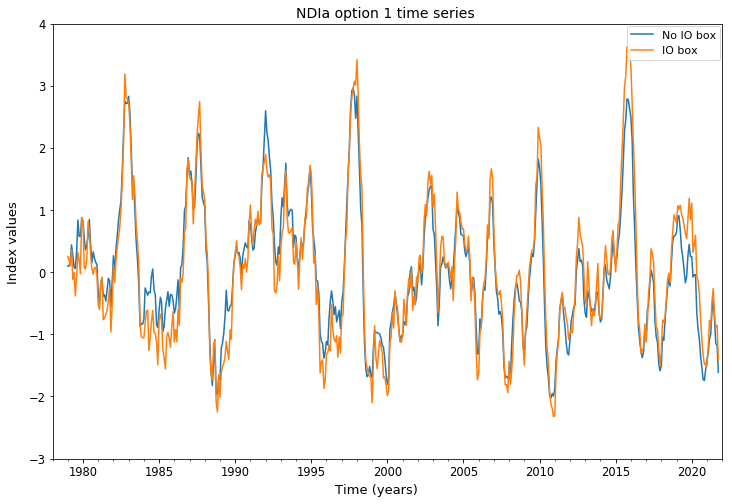

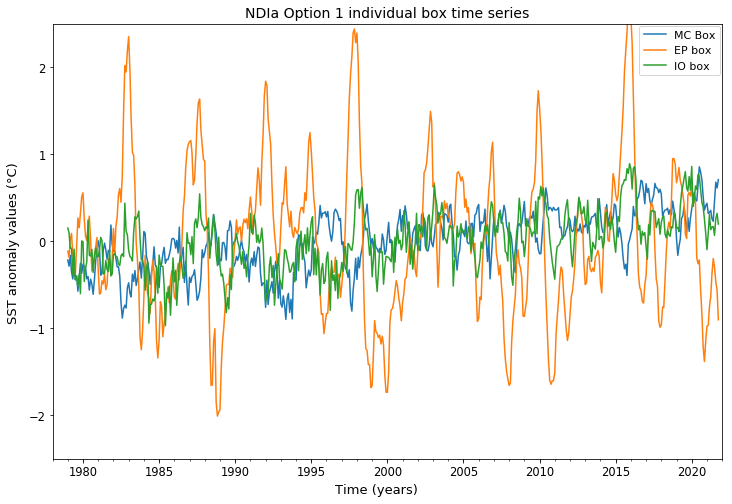

In [50]:
'''
   Plots
'''
#Start index for plots
start_ind_plot = int(np.where(SSTdtime_pd == '1979-01-01')[0])

#end index for plots
end_ind_plot = int(np.where(SSTdtime_pd == '2021-10-01')[0]) + 1

time_axis = SSTdtime_pd[start_ind_plot:end_ind_plot]

legend_info_1 = ['No IO box','IO box']
legend_info_2 = ['MC Box','EP box','IO box']

#since start index of plot is
#same as start index of data
s_ind_data = 0

for plots in range(2):
    '''Plot data'''
    fig = plt.figure(figsize=(12,8))
    ax = fig.add_subplot(1,1,1)

    if plots == 0:
        NDIa_plot = ax.plot(time_axis,NDIa_opt_1[s_ind_data:])
        NDIa_io_plot =ax.plot(time_axis,NDIa_opt_1_io[s_ind_data:])
        plt.title('NDIa option 1 time series ',fontsize = '14')
    else:
        mc_box_plot = ax.plot(time_axis,SSTa_monthly_boxes[0,s_ind_data:])
        ep_box_plot = ax.plot(time_axis,SSTa_monthly_boxes[1,s_ind_data:])
        io_box_plot = ax.plot(time_axis,SSTa_monthly_boxes[2,s_ind_data:])
        plt.title('NDIa Option 1 individual box time series',fontsize='14')

    #set x-limit of plot with datetime
    ax.set_xlim([dt.date(1978, 1, 1), dt.date(2022, 1, 1)])
    #Set major and minor dateticks 
    ax.xaxis.set_major_locator(mdates.YearLocator(5)) 
    date_form = DateFormatter("%Y")
    ax.xaxis.set_major_formatter(date_form)
    ax.xaxis.set_minor_locator(mdates.YearLocator(1)) 
    if plots == 0:
        ax.set_ylim([-2.5,4])
        ax.set_yticks(np.arange(-3,5,1))
    else:
        ax.set_ylim([-2.5,2.5])
        ax.set_yticks(np.arange(-2,3,1))
        
    ax.tick_params(axis='both',labelsize=11.5)
    # Set x and y labels
    fig.text(0.5, 0.07, 'Time (years)', ha='center', va='center', fontsize = 13)
    if plots == 0:
        fig.text(0.08, 0.5, 'Index values', ha='center', va='center', rotation='vertical', fontsize = 13)
    else:
        fig.text(0.08, 0.5, 'SST anomaly values (°C)', ha='center', va='center', rotation='vertical', fontsize = 13)
        
    #legend
    if plots == 0:
        fig.legend([NDIa_plot,NDIa_io_plot], labels=legend_info_1,
                   bbox_to_anchor = (0.84,0.84),fontsize = 11)
    else:
        fig.legend([mc_box_plot,ep_box_plot,io_box_plot], labels=legend_info_2,
                   bbox_to_anchor = (0.84,0.84),fontsize = 11)